In [83]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train.astype("float32"), y_train, test_size=0.1)
y_train, y_test = y_train[:, 0], y_test[:, 0]

In [84]:
from skimage.transform import resize
import scipy.io as sio
'''
(X_ood, _), _ = keras.datasets.mnist.load_data()

X_ood = X_ood[np.random.choice(range(len(X_ood)), int(len(X_ood) / 20))]

_X_ood = np.zeros((len(X_ood), 28, 28, 3))

for k in range(3):
    _X_ood[:, :, :, k] = X_ood

X_ood = np.array([resize(_X_ood[i], (32, 32)) for i in tqdm(range(len(X_ood)))])

indices_of_ood_subclasses = np.where(y_train >= 2)[0]
indices_of_ood_subclasses = np.random.choice(indices_of_ood_subclasses, int(len(X_train) / 20))
X_ood = X_train[indices_of_ood_subclasses]
'''
train_data = sio.loadmat('train_32x32.mat')
X_ood = train_data['X']
_X_ood = np.zeros((np.shape(X_ood)[-1], np.shape(X_train)[1], np.shape(X_train)[2], np.shape(X_train)[3]))
for i in range(np.shape(X_ood)[-1]):
    _X_ood[i] = X_ood[:, :, :, i]
X_ood = _X_ood
X_ood = X_ood[np.random.choice(range(len(X_ood)), int(len(X_ood) / 20))].astype("float32")

In [85]:

indices_of_subclasses = np.where(y_train < 10)[0]
X_train, y_train = X_train[indices_of_subclasses], y_train[indices_of_subclasses]

indices_of_subclasses = np.where(y_val < 10)[0]
X_val, y_val = X_val[indices_of_subclasses], y_val[indices_of_subclasses]

indices_of_subclasses = np.where(y_test < 10)[0]
X_test, y_test = X_test[indices_of_subclasses], y_test[indices_of_subclasses]

In [101]:
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add, Dropout, Activation, Lambda, Input
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        p = 0.25
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.bn_1_1 = BatchNormalization()
        self.drop_1_1 = Dropout(p)
        self.res_1_2 = ResnetBlock(64)
        self.bn_1_2 = BatchNormalization()
        self.drop_1_2 = Dropout(p)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.bn_2_1 = BatchNormalization()
        self.drop_2_1 = Dropout(p)
        self.res_2_2 = ResnetBlock(128)
        self.bn_2_2 = BatchNormalization()
        self.drop_2_2 = Dropout(p)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.bn_3_1 = BatchNormalization()
        self.drop_3_1 = Dropout(p)
        self.res_3_2 = ResnetBlock(256)
        self.bn_3_2 = BatchNormalization()
        self.drop_3_2 = Dropout(p)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.bn_4_1 = BatchNormalization()
        self.drop_4_1 = Dropout(p)
        self.res_4_2 = ResnetBlock(512)
        self.bn_4_2 = BatchNormalization()
        self.drop_4_2 = Dropout(p)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten(name = "enc")
        self.fc = Dense(num_classes, activation="linear")
        self.softmax = Activation('softmax')
        
        self.dns1 = Dense(128, name = "ooddns1")
        self.dns2 = Dense(128, name = "ooddns2")
        self.dns3 = Dense(128, name = "ooddns3")
        self.dns_bn1 = BatchNormalization(name = "oodbn1")
        self.dns_bn2 = BatchNormalization(name = "oodbn2")
        self.dns_bn3 = BatchNormalization(name = "oodbn3")
        self.dns_do1 = Dropout(0.2, name = "ooddo1")
        self.dns_do2 = Dropout(0.2, name = "ooddo2")
        self.dns_do3 = Dropout(0.2, name = "ooddo3")
        self.pre_temperature = Dense(units = 1, activation = 'linear', name = "oodpt")
        self.temperature = Activation(lambda v : tf.where(v < 0, keras.activations.exponential(v / 100), 1 + keras.activations.linear(v)), name = "oodt")
        self.ood_softmax = Activation('softmax', name = "oodsoftmax")
        

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block, bn, drop in zip([self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2], [self.bn_1_1, self.bn_1_2, self.bn_2_1, self.bn_2_2, self.bn_3_1, self.bn_3_2, self.bn_4_1, self.bn_4_2], [self.drop_1_1, self.drop_1_2, self.drop_2_1, self.drop_2_2, self.drop_3_1, self.drop_3_2, self.drop_4_1, self.drop_4_2]):
            out = res_block(out)
            out = bn(out)
            out = drop(out)
        out = self.avg_pool(out)
        enc = self.flat(out)
        logits = self.fc(enc)
        out = self.softmax(logits)
        
        ood_out = self.dns1(enc)
        ood_out = self.dns_bn1(ood_out)
        ood_out = self.dns_do1(ood_out)
        ood_out = self.dns2(ood_out)
        ood_out = self.dns_bn2(ood_out)
        ood_out = self.dns_do2(ood_out)
        ood_out = self.dns3(ood_out)
        ood_out = self.dns_bn3(ood_out)
        ood_out = self.dns_do3(ood_out)
        ood_pt = self.pre_temperature(ood_out)
        ood_t = self.temperature(ood_pt)
        ood_out = logits / ood_t
        ood_out = self.ood_softmax(ood_out)
        
        return out
    
model = ResNet18(10)
model.build((None, 32, 32, 3))

for layer in model.layers:
    if layer.name == "oodt":
        temperature_layer = layer
    elif layer.name == "enc":
        encoder_layer = layer
    elif layer.name == "oodsoftmax":
        ood_out_layer = layer
model.call(Input((32, 32, 3)))

temperature_model = keras.models.Model(inputs = encoder_layer.output, outputs = temperature_layer.output)
ood_network = keras.models.Model(inputs = encoder_layer.output, outputs = ood_out_layer.output)
encoder = keras.models.Model(inputs = model.layers[0].input, outputs = encoder_layer.output)

ood_network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=1e-4))


model.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4),
          metrics = ['acc'])
model.fit(X_train, keras.utils.to_categorical(y_train), 
    epochs = 20,
    verbose = 1,
    validation_split = .1)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/20
1266/1266 [==============================] - 24s 16ms/step - loss: 2.2675 - acc: 0.2352 - val_loss: 1.7833 - val_acc: 0.3509
Epoch 2/20
1266/1266 [==============================] - 20s 16ms/step - loss: 1.7329 - acc: 0.3720 - val_loss: 1.5576 - val_acc: 0.4424
Epoch 3/20
1266/1266 [==============================] - 20s 16ms/step - loss: 1.5221 - acc: 0.4473 - val_loss: 1.3985 - val_acc: 0.5016
Epoch 4/20
1266/1266 [==============================] - 20s 16ms/step - loss: 1.3708 - acc: 0.5077 - val_loss: 1.2238 - val_acc: 0.5642
Epoch 5/20
1266/1266 [==============================] - 20s 16ms/step - loss: 1.2581 - acc: 0.5519 - val_loss: 1.1989 - val_acc: 0.5727
Epoch 6/20
1266/1266 [========================

In [102]:
encoding_X_train = encoder.predict(X_train).reshape(X_train.shape[0], -1)
encoding_X_val = encoder.predict(X_val).reshape(X_val.shape[0], -1)
encoding_X_test = encoder.predict(X_test).reshape(X_test.shape[0], -1)

313/313 [==============================] - 2s 4ms/step


In [103]:
encoding_X_ood = encoder.predict(X_ood).reshape(X_ood.shape[0], -1)

115/115 [==============================] - 1s 4ms/step


In [104]:
from scipy.spatial.distance import cosine
class_means, class_lower_percentile, class_upper_percentile, class_mean_percentile = [], [], [], []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_val == c)[0]
    class_means.append(np.mean(encoding_X_val[examples_of_class], axis = 0))
    class_lower_percentile.append(np.percentile([cosine(encoding_X_val[i], class_means[c]) for i in examples_of_class], 60))
    class_upper_percentile.append(np.percentile([cosine(encoding_X_val[i], class_means[c]) for i in examples_of_class], 100))
    class_mean_percentile.append(np.percentile([cosine(encoding_X_val[i], class_means[c]) for i in examples_of_class], 50))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.91it/s]


In [105]:
from scipy.stats import multivariate_normal as mv
import matplotlib.pyplot as plt
'''
direction_similarity_threshold_per_class = []
for c in tqdm(range(len(np.unique(y_train)))):
    vos_samples_of_class = []
    examples_of_class = np.where(y_val == c)[0]
    vos_samples_of_class = mv.rvs(mean = 0, cov = 1, size = (int(len(examples_of_class)), np.shape(encoding_X_val)[1]))
    vos_samples_of_class = vos_samples_of_class / np.linalg.norm(vos_samples_of_class, axis =1)[:, np.newaxis]
    magnitudes = class_upper_percentile[c] - class_upper_percentile[c] * np.random.exponential(scale = 0.5, size = len(vos_samples_of_class))#np.random.uniform(class_lower_percentile[c], class_upper_percentile[c], size = len(vos_samples_of_class))
    positive_magnitudes = np.where(magnitudes > 0)[0]
    vos_samples_of_class = class_means[c] + vos_samples_of_class[positive_magnitudes] * magnitudes[positive_magnitudes, np.newaxis]
    for sample in vos_samples_of_class:
        direction_from_generating_class = sample - class_means[c]
        max_direction_similarity = 0
        close_classes = [c]
        for j in range(len(np.unique(y_val))):
            if j != c:
                direction_from_other_class_center = sample - class_means[j]
                direction_similarity = 1 - cosine(direction_from_generating_class, direction_from_other_class_center)
                if direction_similarity > max_direction_similarity:
                    max_direction_similarity = direction_similarity
        if max_direction_similarity < .1:
            
    direction_similarity_threshold_per_class.append(np.percentile(directions_of_class, 100 * (2 / len(np.unique(y_train)))))
'''
vos_samples = []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_val == c)[0]
    vos_samples_of_class = []
    while len(vos_samples_of_class) < int(len(examples_of_class) / 10):
        vos_sample_of_class = mv.rvs(mean = 0, cov = 1, size = (np.shape(encoding_X_val)[1]))
        vos_sample_of_class = vos_sample_of_class / np.linalg.norm(vos_sample_of_class)
        magnitude = class_upper_percentile[c] - class_upper_percentile[c] * np.random.exponential(scale = 0.2)
        if magnitude <= 0:
            continue
        vos_sample_of_class = class_means[c] + vos_sample_of_class * magnitude
        direction_from_generating_class = vos_sample_of_class - class_means[c]
        max_direction_similarity = 0
        close_classes = [c]
        for j in range(len(np.unique(y_val))):
            if j != c:
                direction_from_other_class_center = vos_sample_of_class - class_means[j]
                direction_similarity = 1 - cosine(direction_from_generating_class, direction_from_other_class_center)
                if direction_similarity > max_direction_similarity:
                    max_direction_similarity = direction_similarity
        if max_direction_similarity < .05:
            vos_samples_of_class.append(vos_sample_of_class)
    vos_samples.extend(vos_samples_of_class)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


In [106]:
vos_labels = np.ones((len(vos_samples), len(np.unique(y_val)))) / len(np.unique(y_val))

In [107]:
ood_X_val = np.concatenate([encoding_X_val, vos_samples], axis = 0)
ood_y_val = np.concatenate([keras.utils.to_categorical(np.argmax(model.predict(X_val), axis = 1)), vos_labels])

random_order = np.arange(len(ood_X_val))
np.random.shuffle(random_order)
ood_X_val, ood_y_val = ood_X_val[random_order], ood_y_val[random_order]

157/157 [==============================] - 1s 5ms/step


In [ ]:
for layer in model.layers:
    if "ood" not in layer.name:
        layer.trainable = False
    
ood_network.fit(ood_X_val, ood_y_val, 
    epochs = 200,
    verbose = 1,
    validation_split = .1,
    callbacks = keras.callbacks.EarlyStopping(patience = 10))

Epoch 1/200
155/155 [==============================] - 2s 6ms/step - loss: 0.7549 - val_loss: 0.6996
Epoch 2/200
155/155 [==============================] - 1s 5ms/step - loss: 0.7136 - val_loss: 0.6611
Epoch 3/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6875 - val_loss: 0.6577
Epoch 4/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6756 - val_loss: 0.6375
Epoch 5/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6597 - val_loss: 0.6183
Epoch 6/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6551 - val_loss: 0.6089
Epoch 7/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6499 - val_loss: 0.5884
Epoch 8/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6361 - val_loss: 0.6043
Epoch 9/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6289 - val_loss: 0.5894
Epoch 10/200
155/155 [==============================] - 1s 5ms/step - loss: 0.6180 - val_lo

In [95]:
y_hat_test = ood_network.predict(encoding_X_test)
y_hat_ood = ood_network.predict(encoding_X_ood)

115/115 [==============================] - 0s 2ms/step


115/115 [==============================] - 0s 1ms/step


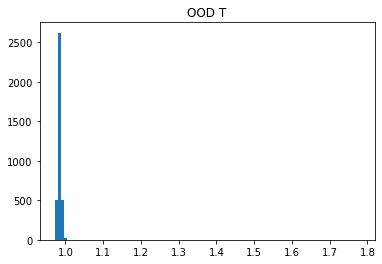

115/115 [==============================] - 0s 2ms/step


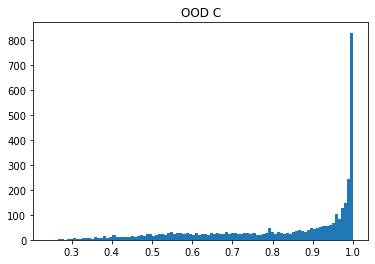

OOD T:  0.98467207
OOD C:  0.8266335
313/313 [==============================] - 0s 1ms/step


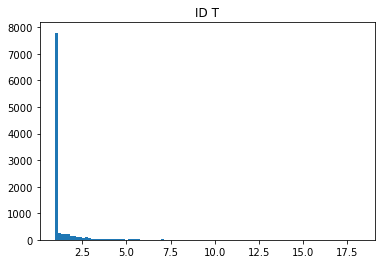

313/313 [==============================] - 1s 2ms/step


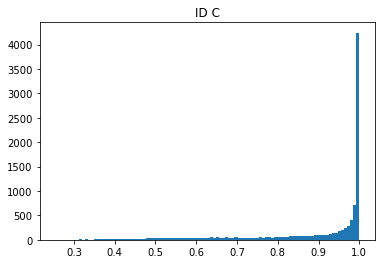

ID T:  1.3799248
ID C:  0.8968197
AUC T:  0.22314337793555433
AUC C:  0.6427944429273621


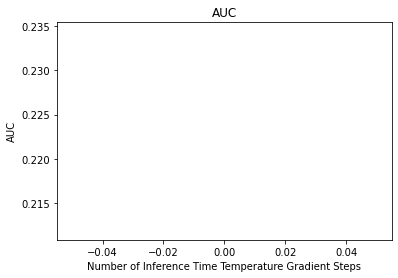

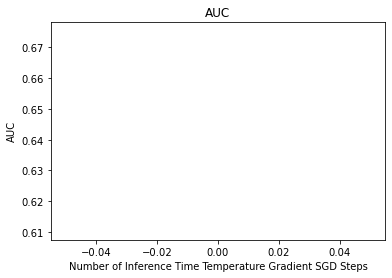

115/115 [==============================] - 0s 2ms/step


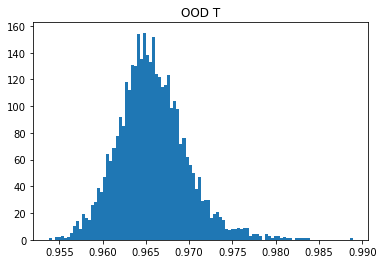

115/115 [==============================] - 0s 2ms/step


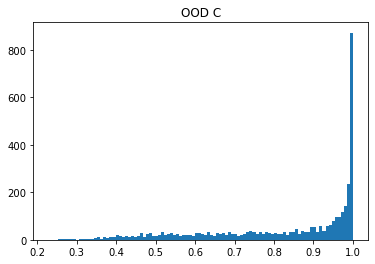

OOD T:  0.96573615
OOD C:  0.828074
313/313 [==============================] - 0s 1ms/step


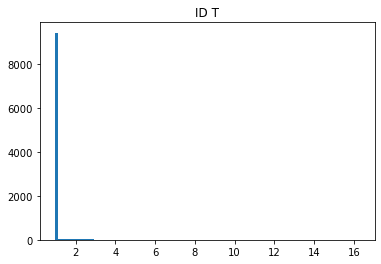

313/313 [==============================] - 1s 2ms/step


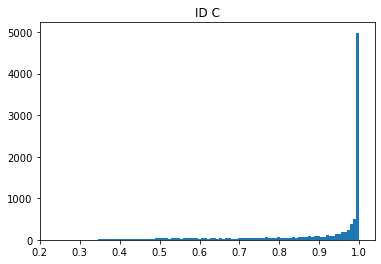

ID T:  1.115634
ID C:  0.90372765
AUC T:  0.22314335062807208
AUC C:  0.6778837520480612


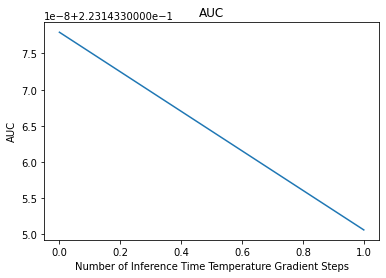

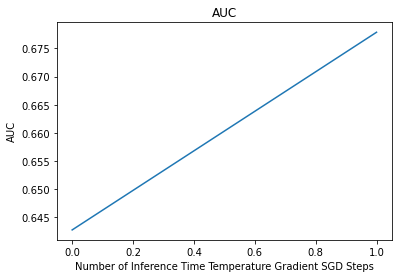

115/115 [==============================] - 0s 1ms/step


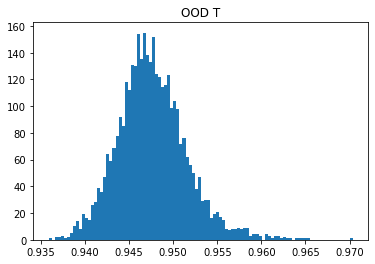

115/115 [==============================] - 0s 2ms/step


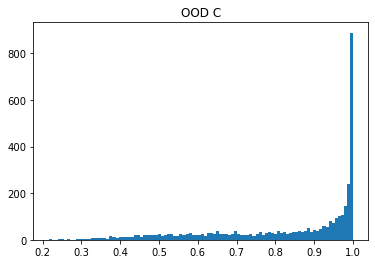

OOD T:  0.94763094
OOD C:  0.8286749
313/313 [==============================] - 0s 1ms/step


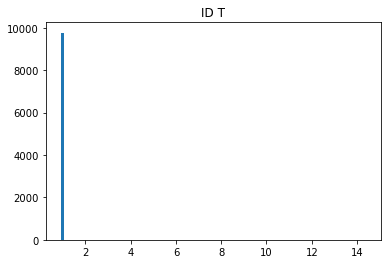

313/313 [==============================] - 1s 2ms/step


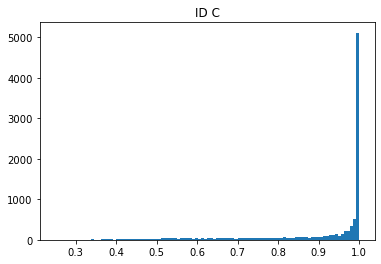

ID T:  1.025497
ID C:  0.90527755
AUC T:  0.22314333697433097
AUC C:  0.6844274713271437


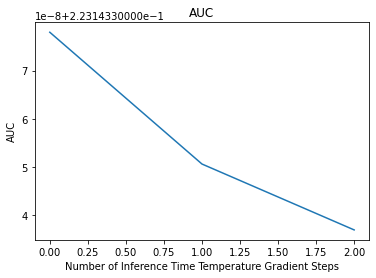

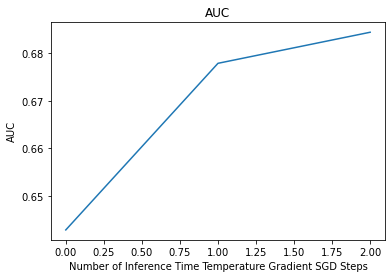

115/115 [==============================] - 0s 1ms/step


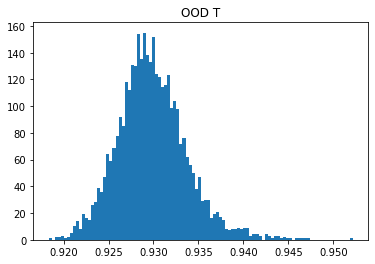

115/115 [==============================] - 0s 2ms/step


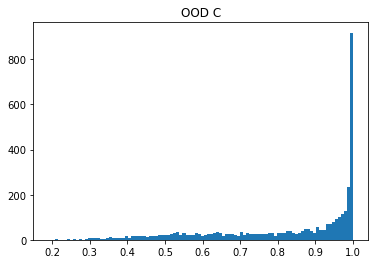

OOD T:  0.92986524
OOD C:  0.8286031
313/313 [==============================] - 0s 1ms/step


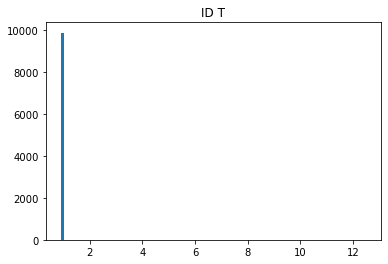

313/313 [==============================] - 1s 2ms/step


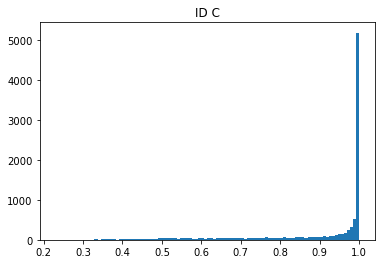

ID T:  0.9741164
ID C:  0.9052474
AUC T:  0.2231432004369197
AUC C:  0.6867116329874385


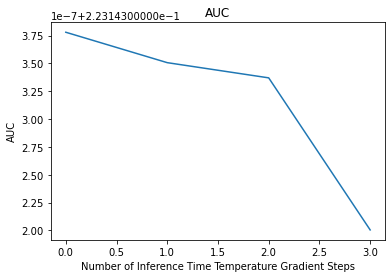

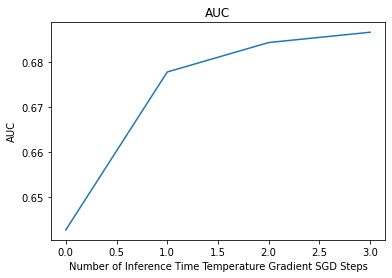

115/115 [==============================] - 0s 1ms/step


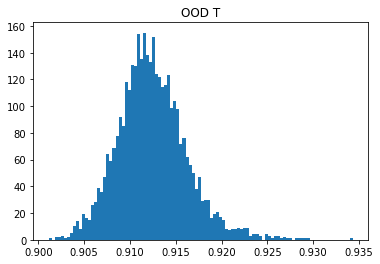

115/115 [==============================] - 0s 2ms/step


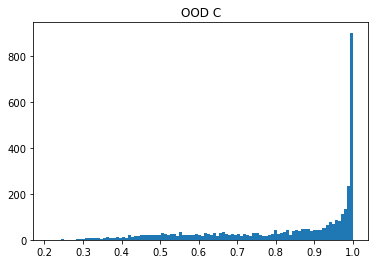

OOD T:  0.9124326
OOD C:  0.8278244
313/313 [==============================] - 0s 1ms/step


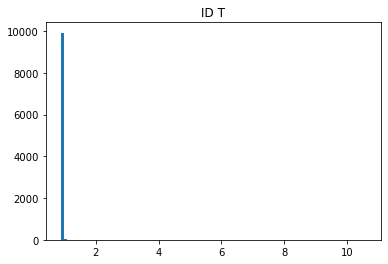

313/313 [==============================] - 1s 2ms/step


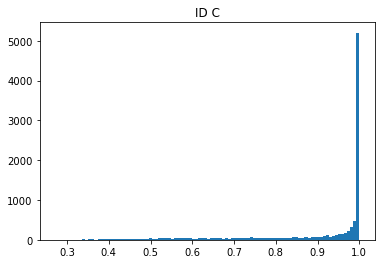

ID T:  0.9381321
ID C:  0.9049262
AUC T:  0.22314326870562534
AUC C:  0.6883151829601311


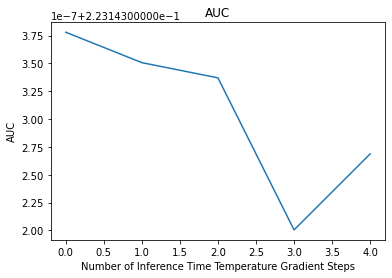

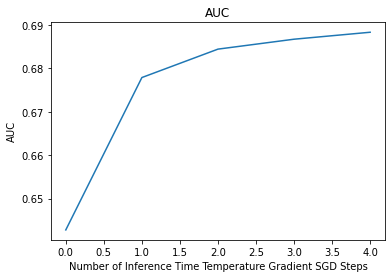

115/115 [==============================] - 0s 1ms/step


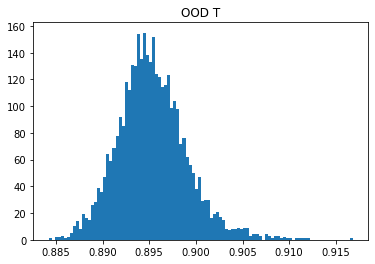

115/115 [==============================] - 0s 2ms/step


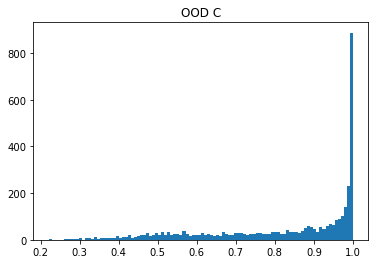

OOD T:  0.89532673
OOD C:  0.82647324
313/313 [==============================] - 0s 1ms/step


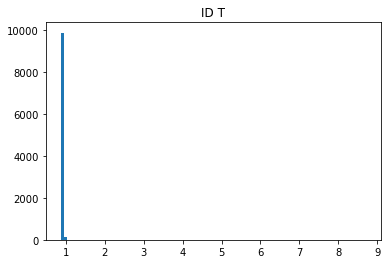

313/313 [==============================] - 1s 2ms/step


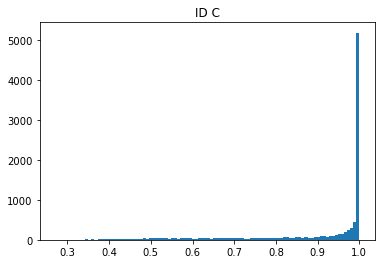

ID T:  0.9118408
ID C:  0.9044664
AUC T:  0.2231432413981431
AUC C:  0.6900504232659749


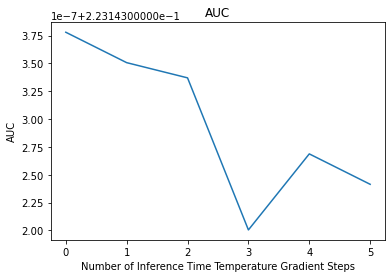

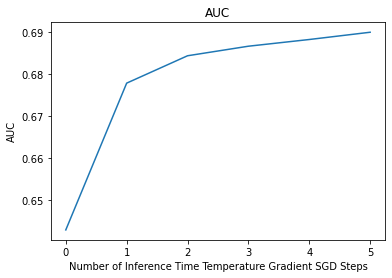

115/115 [==============================] - 0s 1ms/step


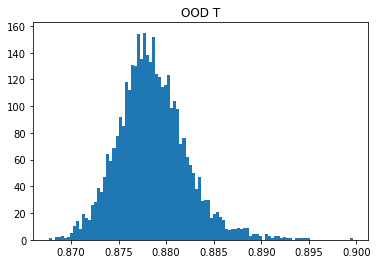

115/115 [==============================] - 0s 2ms/step


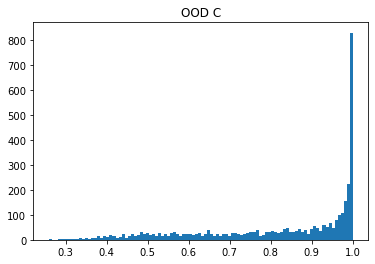

OOD T:  0.8785416
OOD C:  0.82412165
313/313 [==============================] - 0s 1ms/step


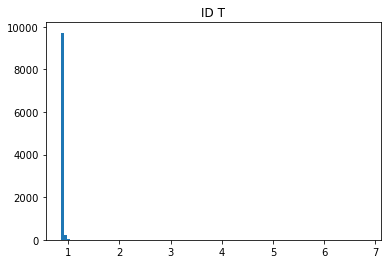

313/313 [==============================] - 1s 2ms/step


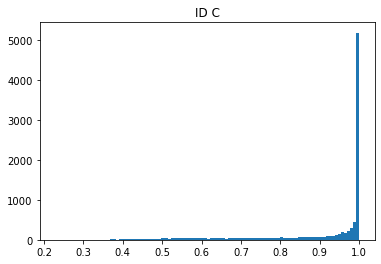

ID T:  0.8906905
ID C:  0.9041632
AUC T:  0.22314321409066085
AUC C:  0.692844224467504


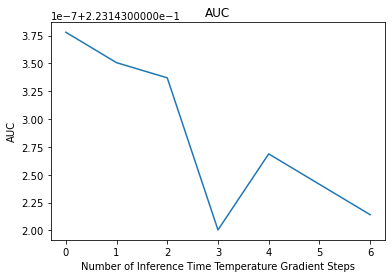

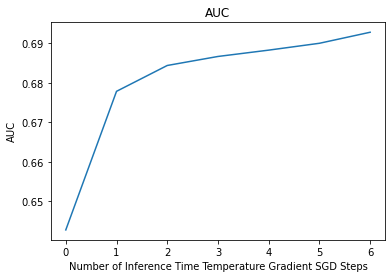

115/115 [==============================] - 0s 1ms/step


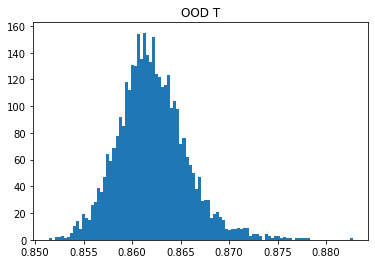

115/115 [==============================] - 0s 2ms/step


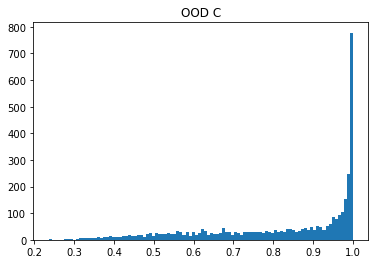

OOD T:  0.86207116
OOD C:  0.82030296
313/313 [==============================] - 0s 1ms/step


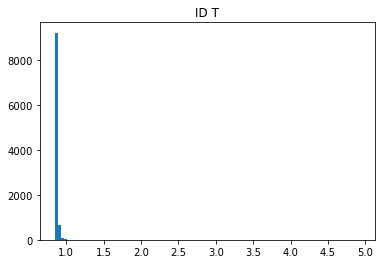

313/313 [==============================] - 1s 2ms/step


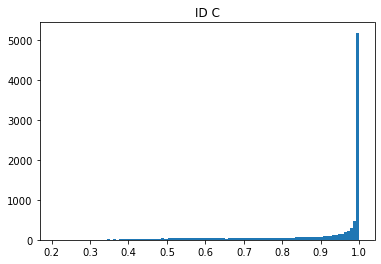

ID T:  0.8725744
ID C:  0.9029497
AUC T:  0.22314326870562537
AUC C:  0.6962406471873293


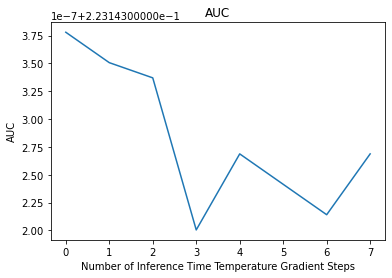

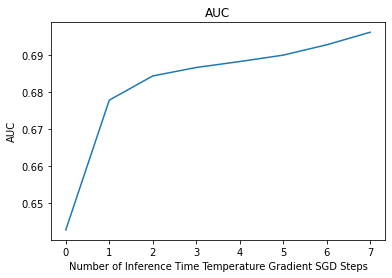

115/115 [==============================] - 0s 1ms/step


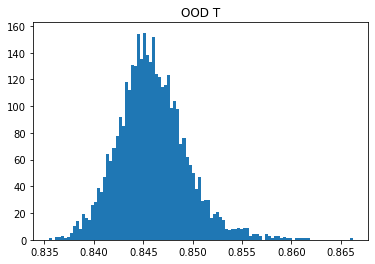

115/115 [==============================] - 0s 2ms/step


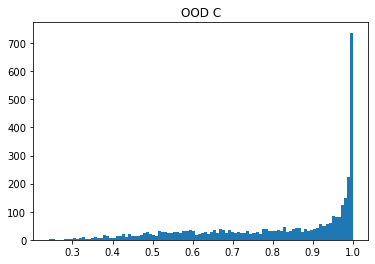

OOD T:  0.8459095
OOD C:  0.8148141
313/313 [==============================] - 0s 1ms/step


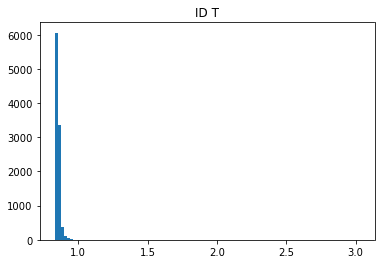

313/313 [==============================] - 1s 2ms/step


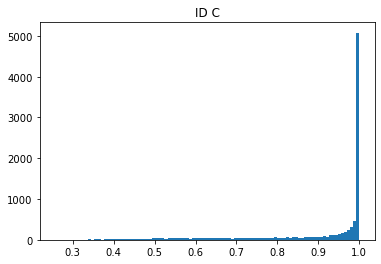

ID T:  0.8556335
ID C:  0.901732
AUC T:  0.22314332332058984
AUC C:  0.7014661933369744


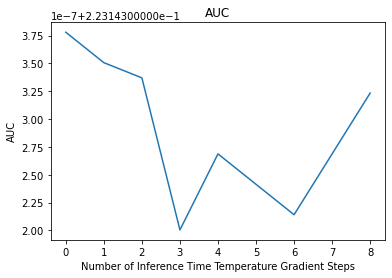

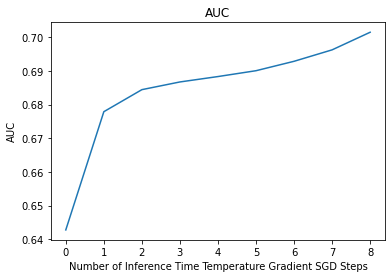

115/115 [==============================] - 0s 1ms/step


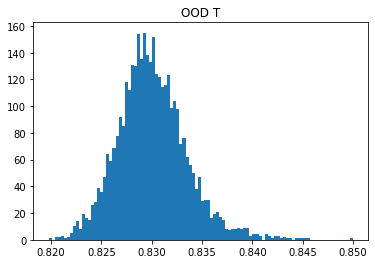

115/115 [==============================] - 0s 2ms/step


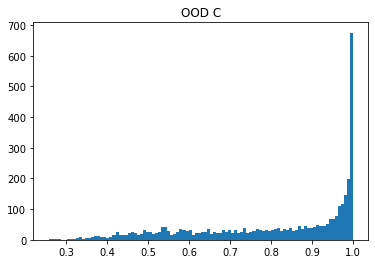

OOD T:  0.83005077
OOD C:  0.8077831
313/313 [==============================] - 0s 1ms/step


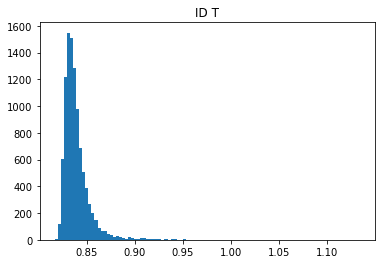

313/313 [==============================] - 1s 2ms/step


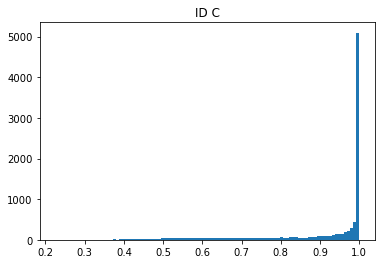

ID T:  0.8393038
ID C:  0.9017441
AUC T:  0.2231434052430366
AUC C:  0.7092917667941017


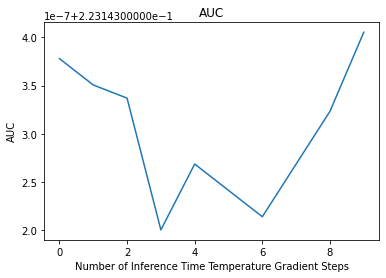

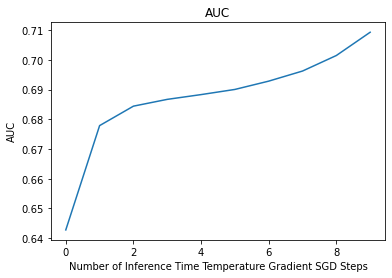

115/115 [==============================] - 0s 2ms/step


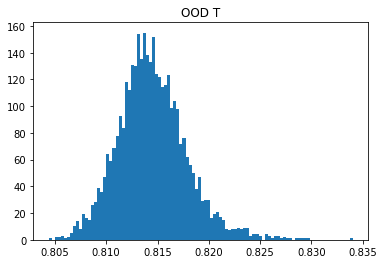

115/115 [==============================] - 0s 2ms/step


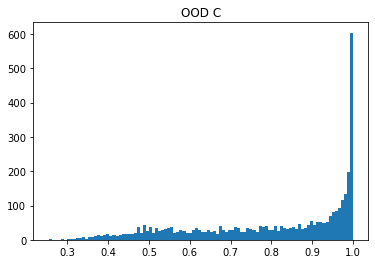

OOD T:  0.81448936
OOD C:  0.8007296
313/313 [==============================] - 0s 1ms/step


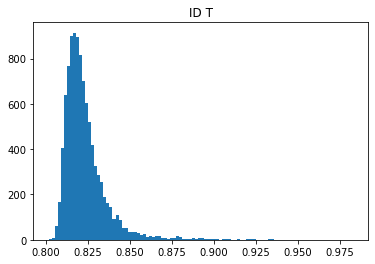

313/313 [==============================] - 1s 2ms/step


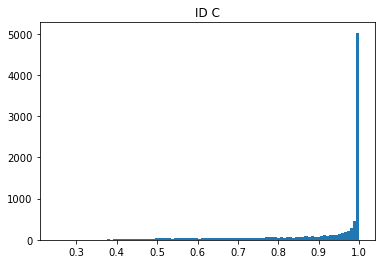

ID T:  0.82355607
ID C:  0.9025402
AUC T:  0.22314333697433097
AUC C:  0.7186356089568542


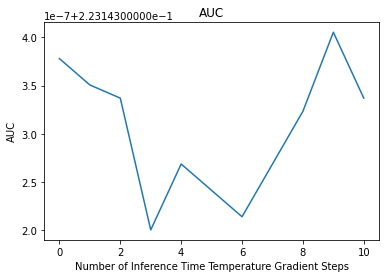

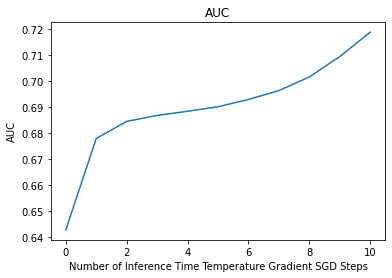

115/115 [==============================] - 0s 1ms/step


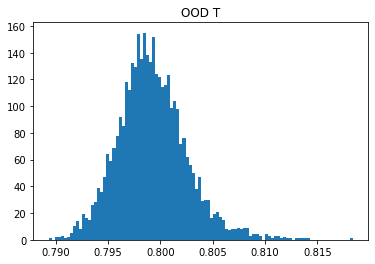

115/115 [==============================] - 0s 2ms/step


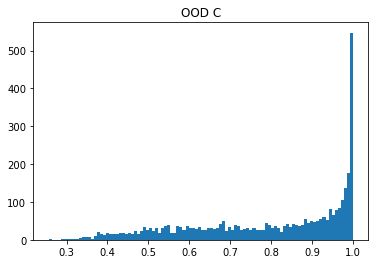

OOD T:  0.7992197
OOD C:  0.7946813
313/313 [==============================] - 0s 1ms/step


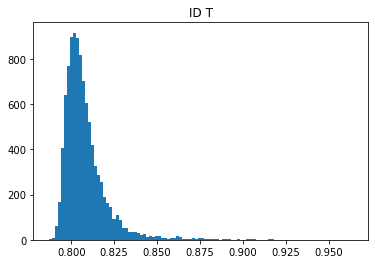

313/313 [==============================] - 1s 2ms/step


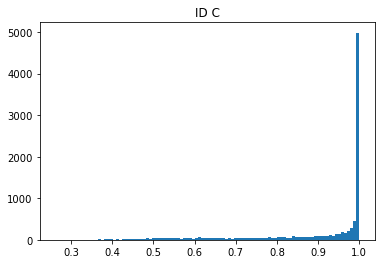

ID T:  0.80811644
ID C:  0.903062
AUC T:  0.22314345985800108
AUC C:  0.7274519115237574


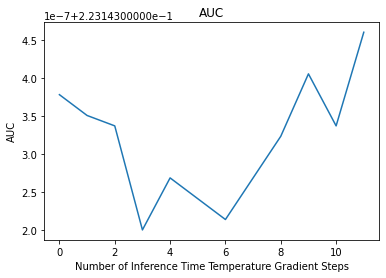

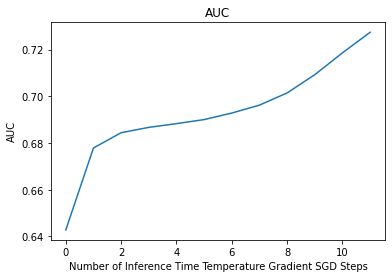

115/115 [==============================] - 0s 2ms/step


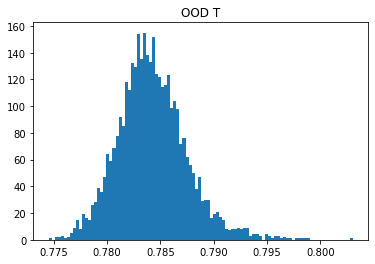

115/115 [==============================] - 0s 2ms/step


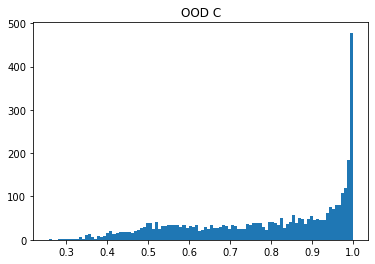

OOD T:  0.7842364
OOD C:  0.78926957
313/313 [==============================] - 0s 1ms/step


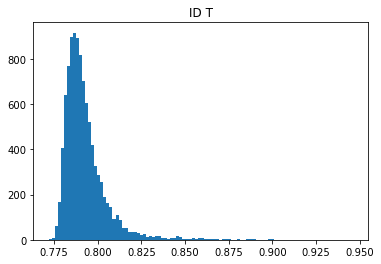

313/313 [==============================] - 1s 2ms/step


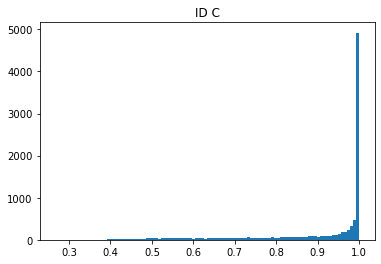

ID T:  0.7929662
ID C:  0.9036966
AUC T:  0.22314344620425997
AUC C:  0.7362176406335336


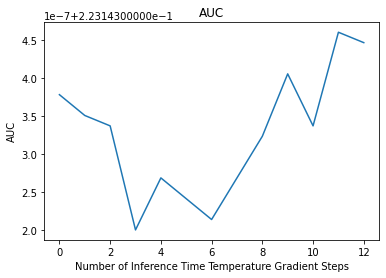

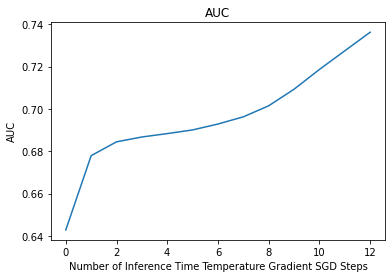

115/115 [==============================] - 0s 1ms/step


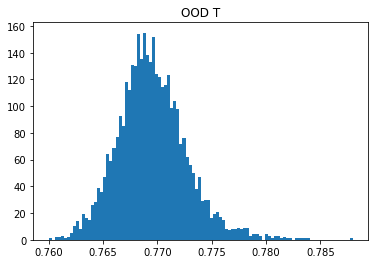

115/115 [==============================] - 0s 2ms/step


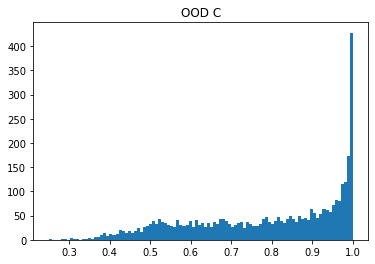

OOD T:  0.7695339
OOD C:  0.78799134
313/313 [==============================] - 0s 2ms/step


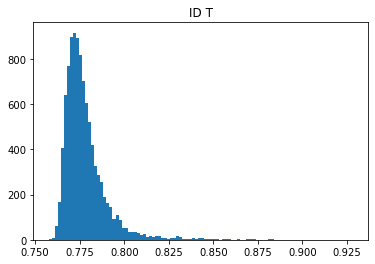

313/313 [==============================] - 1s 2ms/step


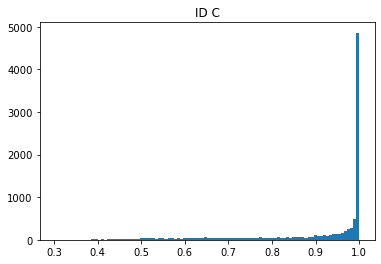

ID T:  0.7781001
ID C:  0.90447986
AUC T:  0.2231434735117422
AUC C:  0.7420515155652649


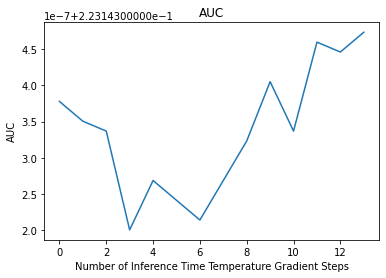

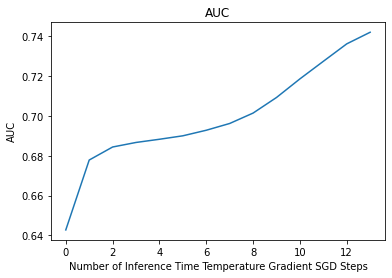

115/115 [==============================] - 0s 1ms/step


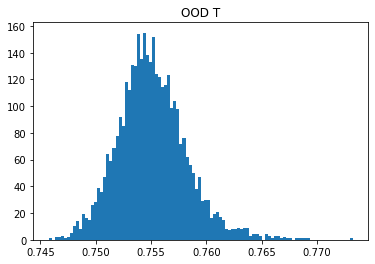

115/115 [==============================] - 0s 2ms/step


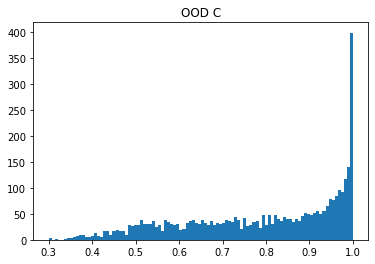

OOD T:  0.75510705
OOD C:  0.79035366
313/313 [==============================] - 0s 1ms/step


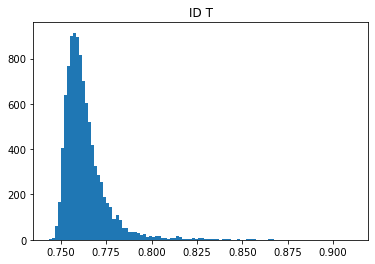

313/313 [==============================] - 1s 2ms/step


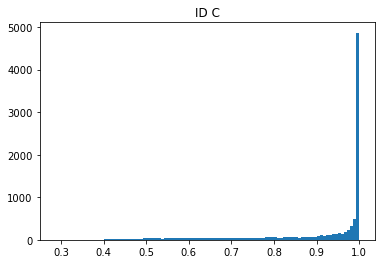

ID T:  0.7635127
ID C:  0.9055653
AUC T:  0.2231433096668487
AUC C:  0.7443774167121792


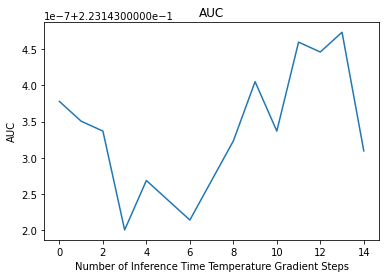

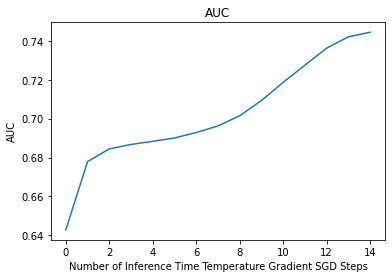

115/115 [==============================] - 0s 1ms/step


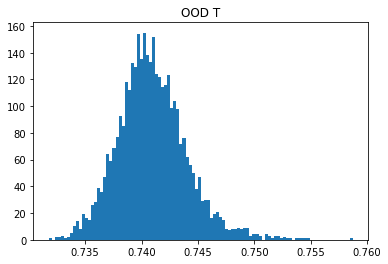

115/115 [==============================] - 0s 2ms/step


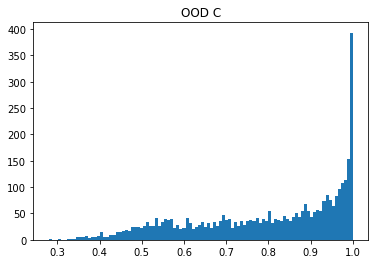

OOD T:  0.74095064
OOD C:  0.7970342
313/313 [==============================] - 0s 1ms/step


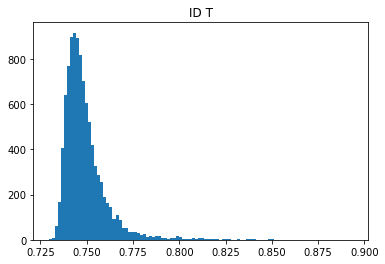

313/313 [==============================] - 1s 2ms/step


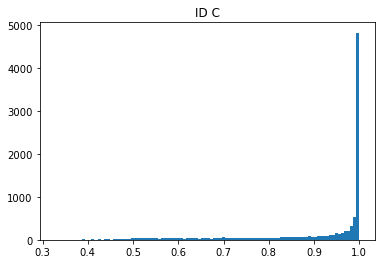

ID T:  0.7491986
ID C:  0.9072064
AUC T:  0.22314324139814312
AUC C:  0.7425755188421628


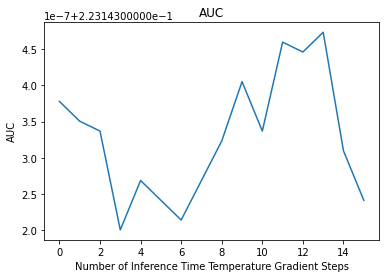

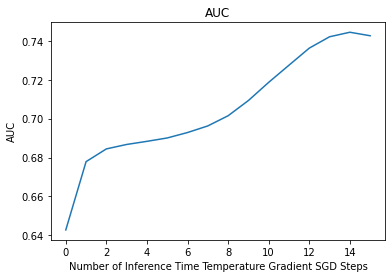

115/115 [==============================] - 0s 1ms/step


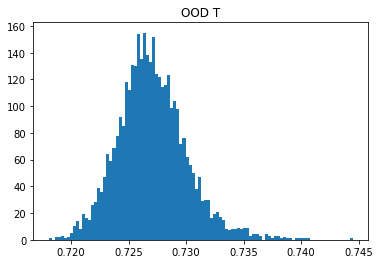

115/115 [==============================] - 0s 2ms/step


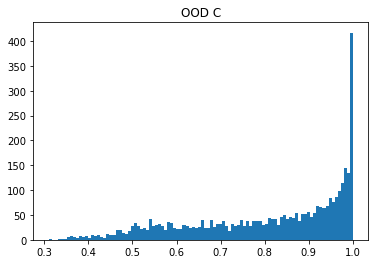

OOD T:  0.72705966
OOD C:  0.80878764
313/313 [==============================] - 0s 1ms/step


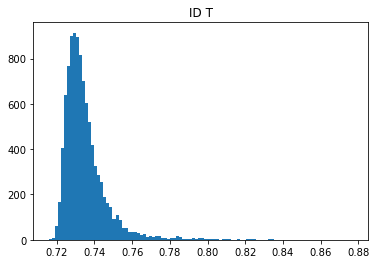

313/313 [==============================] - 1s 2ms/step


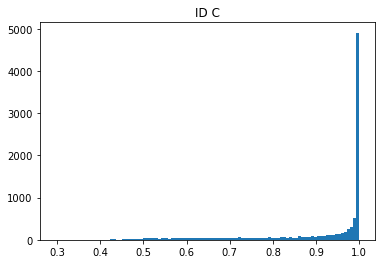

ID T:  0.7351531
ID C:  0.9088588
AUC T:  0.22314330966684873
AUC C:  0.7352615237575096


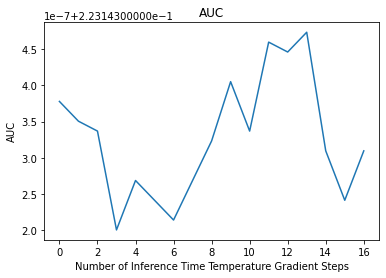

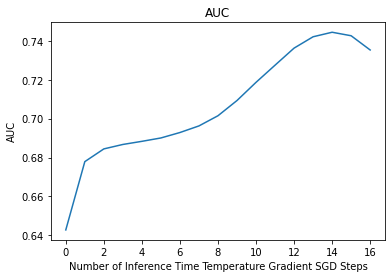

115/115 [==============================] - 0s 1ms/step


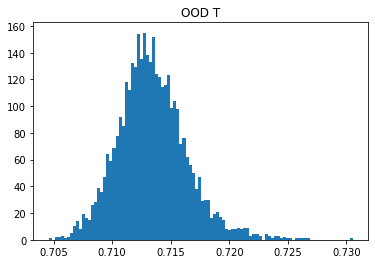

115/115 [==============================] - 0s 2ms/step


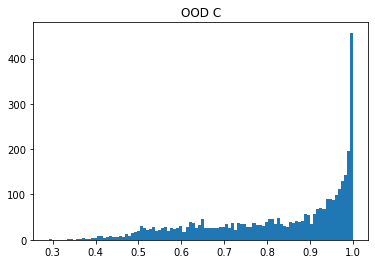

OOD T:  0.71342903
OOD C:  0.82534724
313/313 [==============================] - 0s 1ms/step


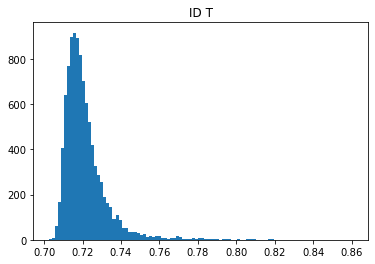

313/313 [==============================] - 1s 2ms/step


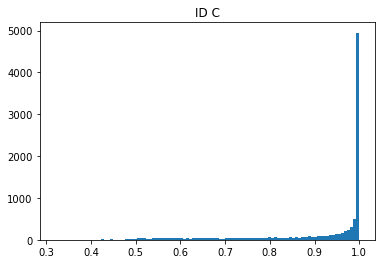

ID T:  0.7213708
ID C:  0.91118515
AUC T:  0.2231434735117422
AUC C:  0.723771627525942


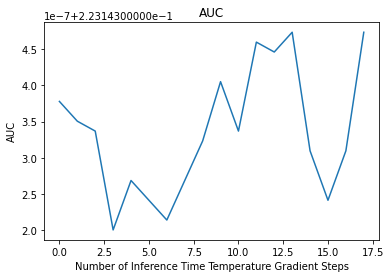

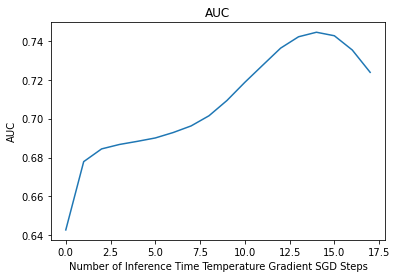

115/115 [==============================] - 0s 1ms/step


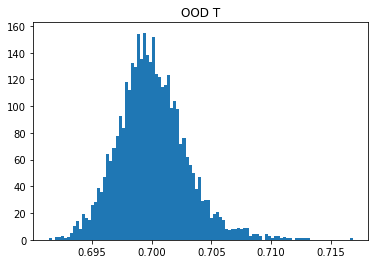

115/115 [==============================] - 0s 2ms/step


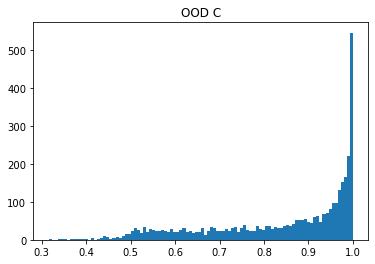

OOD T:  0.70005405
OOD C:  0.8422124
313/313 [==============================] - 0s 1ms/step


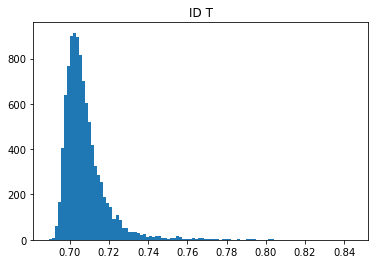

313/313 [==============================] - 1s 2ms/step


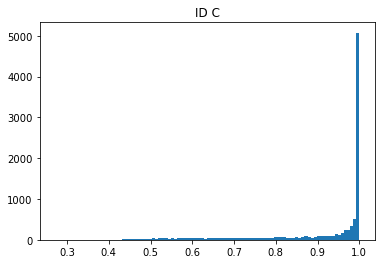

ID T:  0.7078469
ID C:  0.9140968
AUC T:  0.22314322774440196
AUC C:  0.7101164254505734


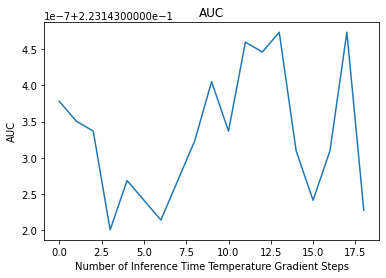

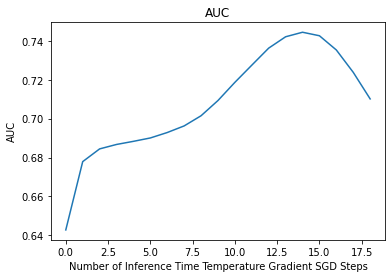

115/115 [==============================] - 0s 1ms/step


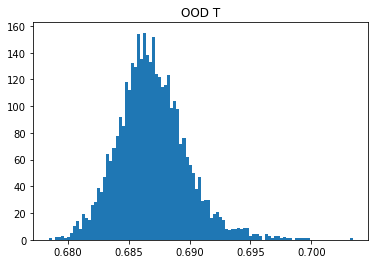

115/115 [==============================] - 0s 2ms/step


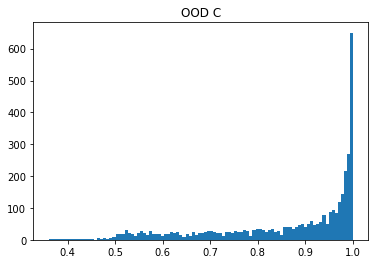

OOD T:  0.68692976
OOD C:  0.8624101
313/313 [==============================] - 0s 1ms/step


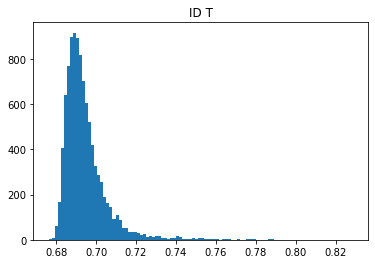

313/313 [==============================] - 1s 2ms/step


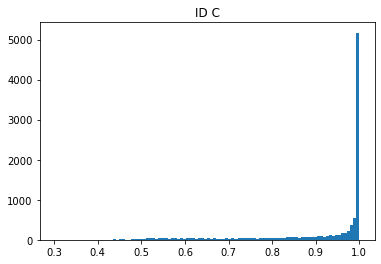

ID T:  0.69457644
ID C:  0.9181639
AUC T:  0.22314321409066085
AUC C:  0.6940071272528674


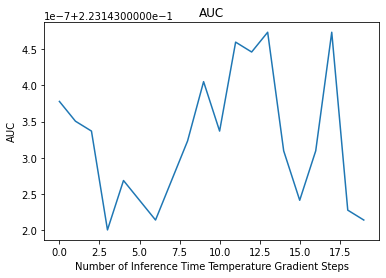

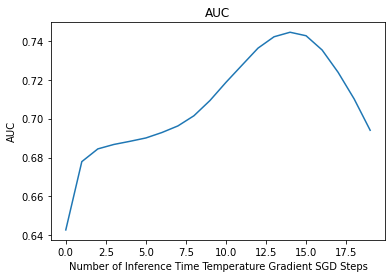

115/115 [==============================] - 0s 1ms/step


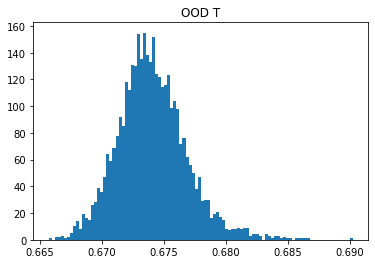

115/115 [==============================] - 0s 2ms/step


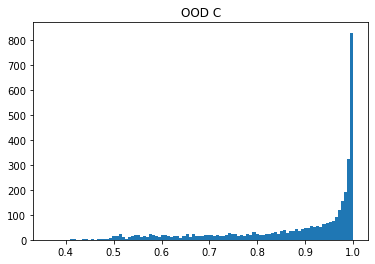

OOD T:  0.6740515
OOD C:  0.88196903
313/313 [==============================] - 0s 1ms/step


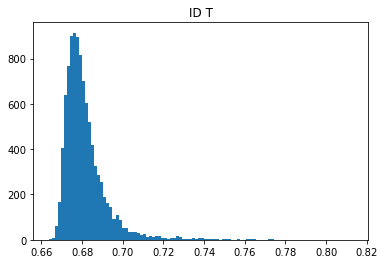

313/313 [==============================] - 1s 2ms/step


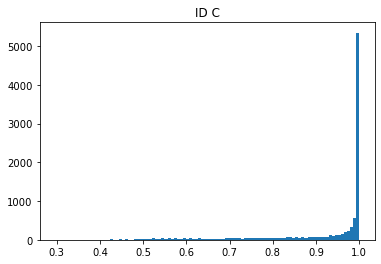

ID T:  0.68155485
ID C:  0.9226292
AUC T:  0.22314321409066085
AUC C:  0.6771549290005461


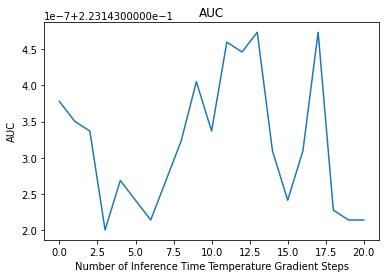

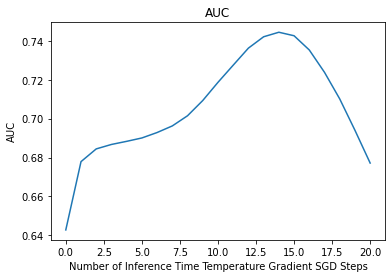

115/115 [==============================] - 0s 1ms/step


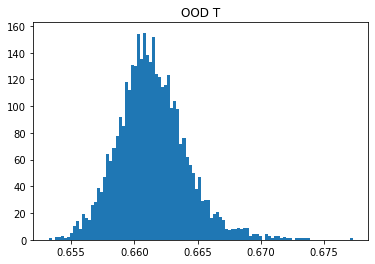

115/115 [==============================] - 0s 2ms/step


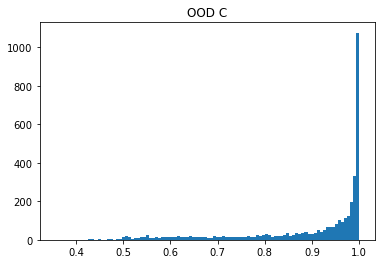

OOD T:  0.6614147
OOD C:  0.899312
313/313 [==============================] - 0s 1ms/step


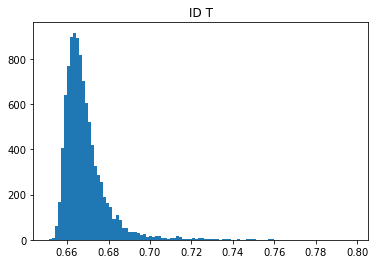

313/313 [==============================] - 1s 2ms/step


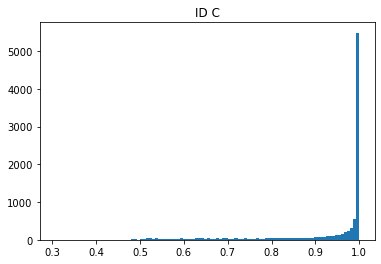

ID T:  0.66877735
ID C:  0.9273452
AUC T:  0.2231431458219552
AUC C:  0.6606907564172584


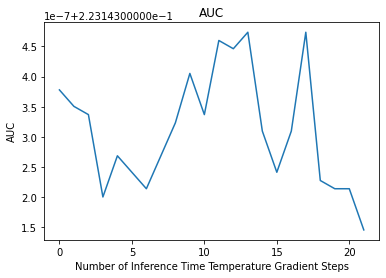

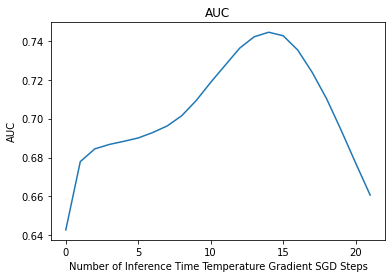

115/115 [==============================] - 0s 1ms/step


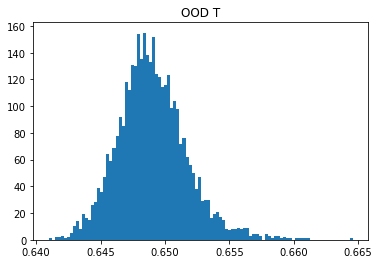

115/115 [==============================] - 0s 2ms/step


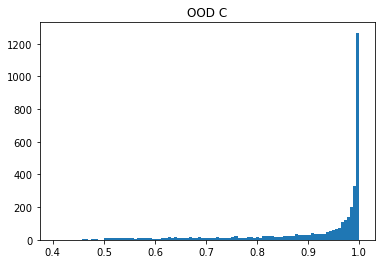

OOD T:  0.64901483
OOD C:  0.91457987
313/313 [==============================] - 0s 1ms/step


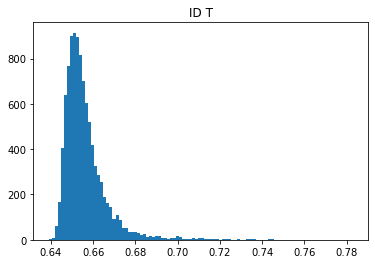

313/313 [==============================] - 1s 2ms/step


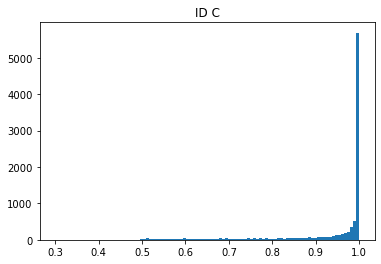

ID T:  0.65623945
ID C:  0.9322163
AUC T:  0.22314305024576733
AUC C:  0.6450351037684325


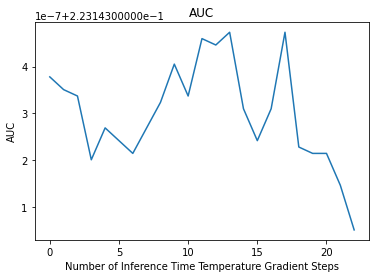

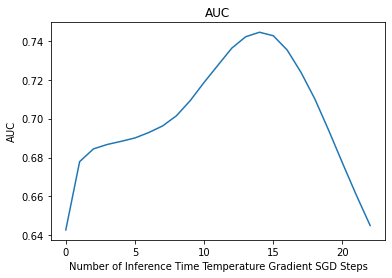

115/115 [==============================] - 0s 1ms/step


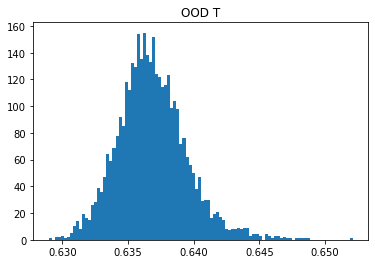

115/115 [==============================] - 0s 2ms/step


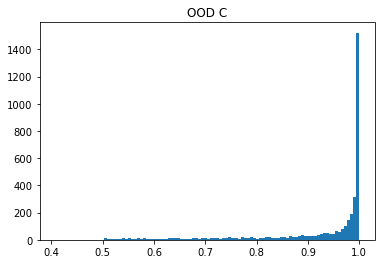

OOD T:  0.63684744
OOD C:  0.9275216
313/313 [==============================] - 0s 1ms/step


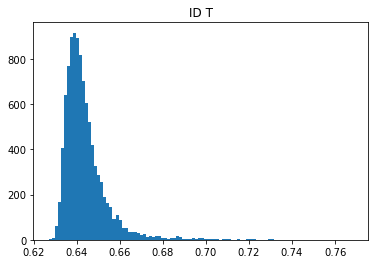

313/313 [==============================] - 1s 2ms/step


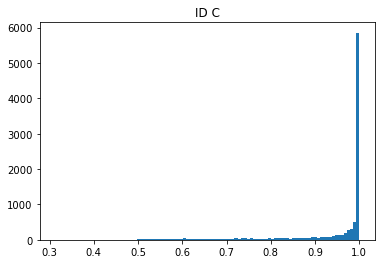

ID T:  0.64393663
ID C:  0.9368467
AUC T:  0.22314336428181325
AUC C:  0.6302638312397597


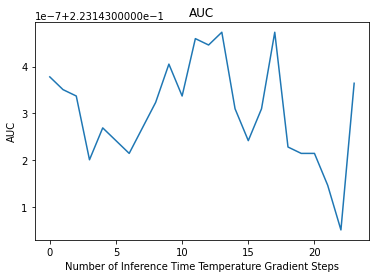

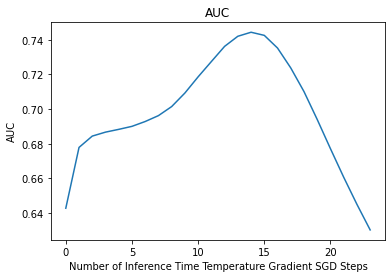

115/115 [==============================] - 0s 2ms/step


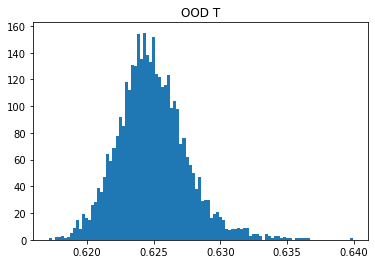

115/115 [==============================] - 0s 2ms/step


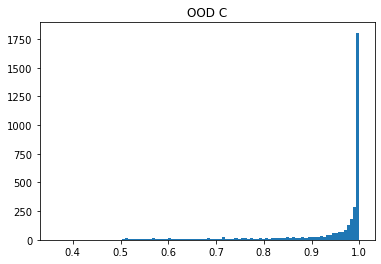

OOD T:  0.62490815
OOD C:  0.9376356
313/313 [==============================] - 0s 1ms/step


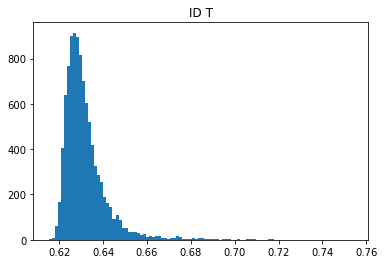

313/313 [==============================] - 1s 2ms/step


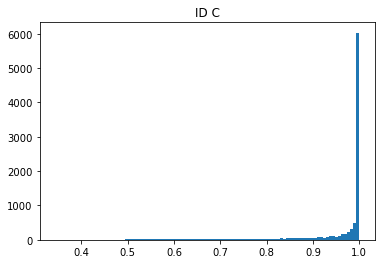

ID T:  0.6318644
ID C:  0.9408368
AUC T:  0.22314325505188423
AUC C:  0.6167861004915347


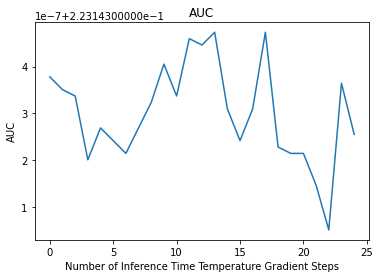

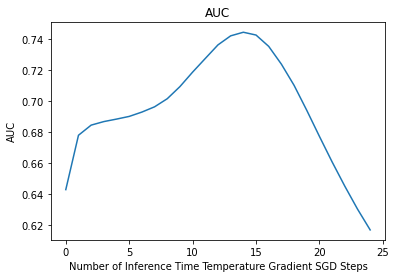

115/115 [==============================] - 0s 2ms/step


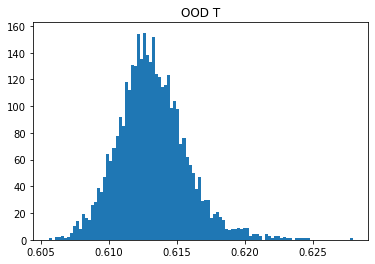

115/115 [==============================] - 0s 2ms/step


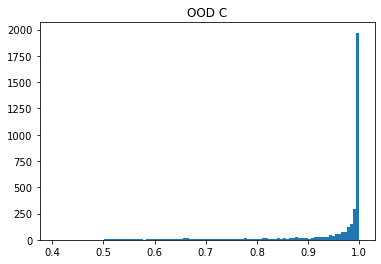

OOD T:  0.61319274
OOD C:  0.94624937
313/313 [==============================] - 0s 1ms/step


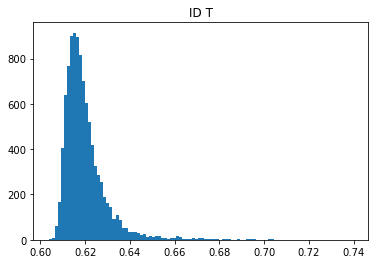

313/313 [==============================] - 1s 2ms/step


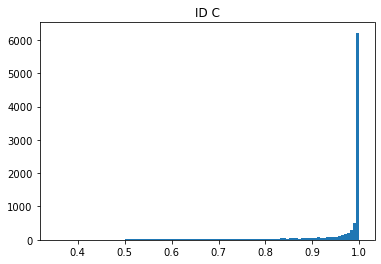

ID T:  0.62001854
ID C:  0.9445943
AUC T:  0.22314298197706173
AUC C:  0.6044966957946477


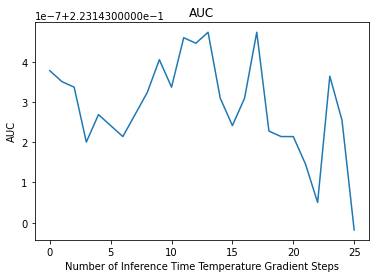

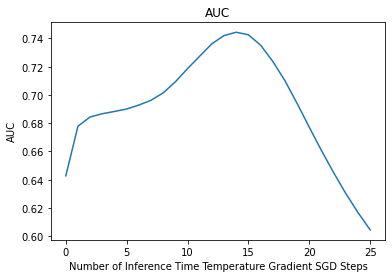

115/115 [==============================] - 0s 1ms/step


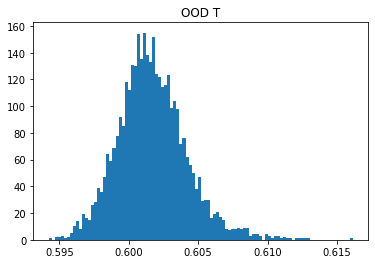

115/115 [==============================] - 0s 2ms/step


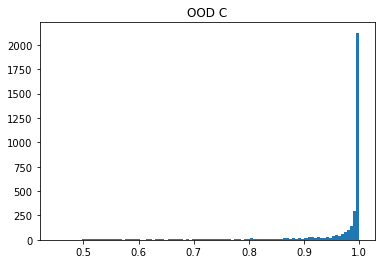

OOD T:  0.6016968
OOD C:  0.953516
313/313 [==============================] - 0s 1ms/step


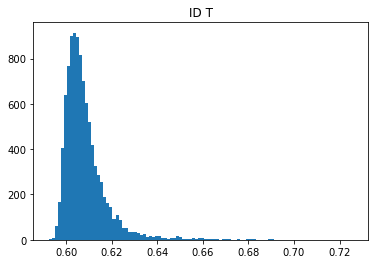

313/313 [==============================] - 1s 2ms/step


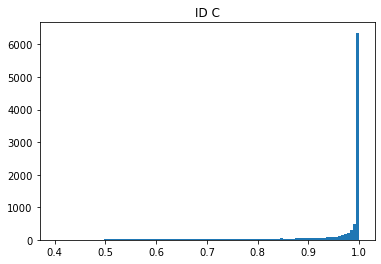

ID T:  0.60839474
ID C:  0.9486922
AUC T:  0.22314303659202622
AUC C:  0.593392586018569


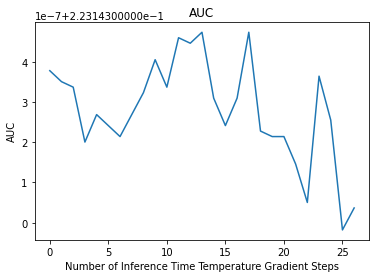

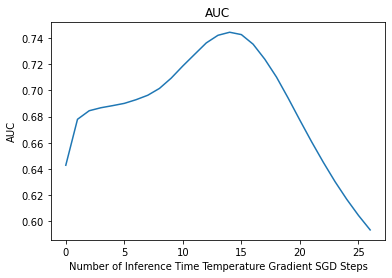

115/115 [==============================] - 0s 1ms/step


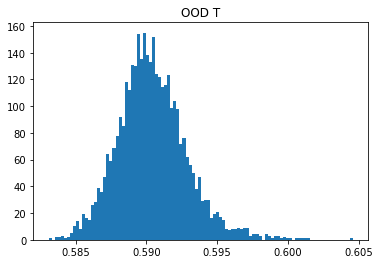

115/115 [==============================] - 0s 2ms/step


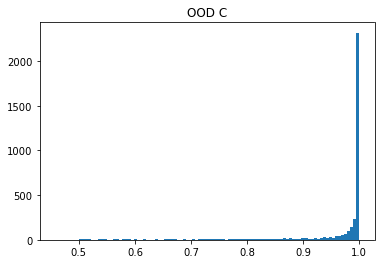

OOD T:  0.59041643
OOD C:  0.9599029
313/313 [==============================] - 0s 1ms/step


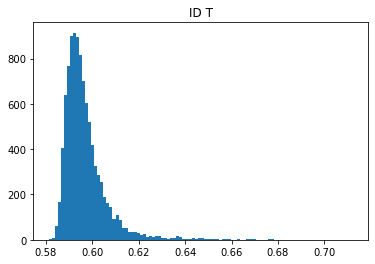

313/313 [==============================] - 1s 2ms/step


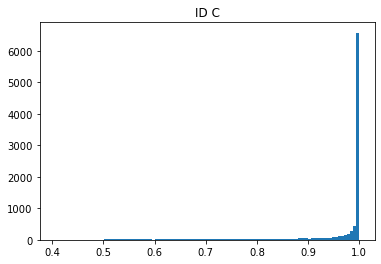

ID T:  0.5969888
ID C:  0.9525486
AUC T:  0.2231432413981431
AUC C:  0.5834341206990715


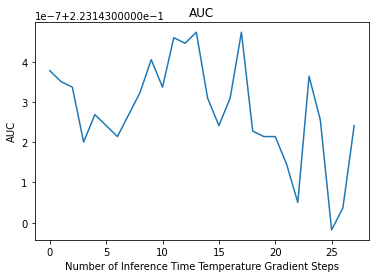

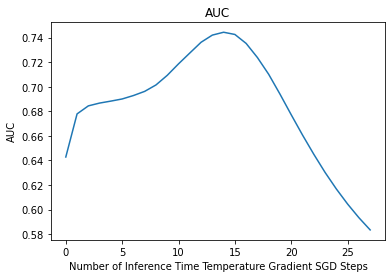

115/115 [==============================] - 0s 1ms/step


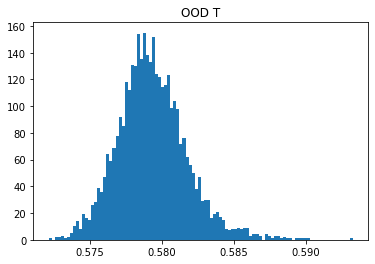

115/115 [==============================] - 0s 2ms/step


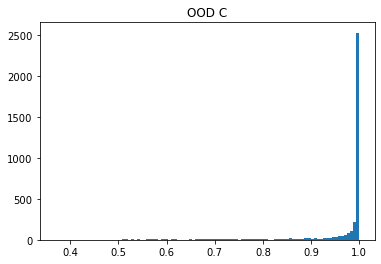

OOD T:  0.5793476
OOD C:  0.96565247
313/313 [==============================] - 0s 1ms/step


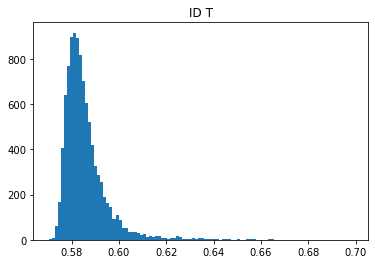

313/313 [==============================] - 1s 2ms/step


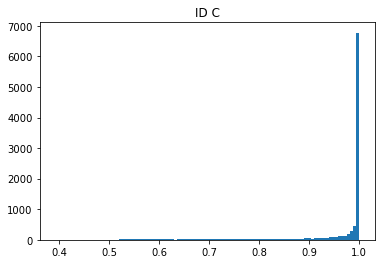

ID T:  0.5857968
ID C:  0.9560452
AUC T:  0.22314306389950844
AUC C:  0.5744420125614418


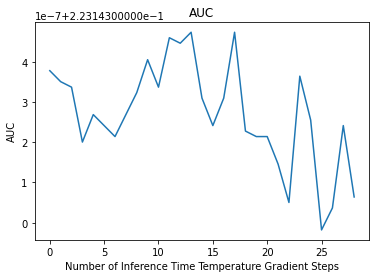

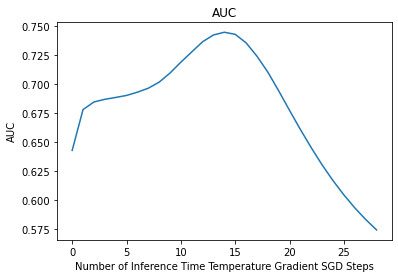

115/115 [==============================] - 0s 1ms/step


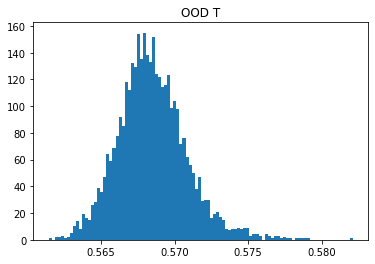

115/115 [==============================] - 0s 2ms/step


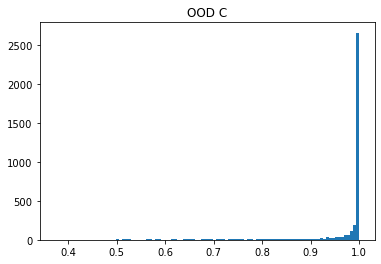

OOD T:  0.56848633
OOD C:  0.9702942
313/313 [==============================] - 0s 1ms/step


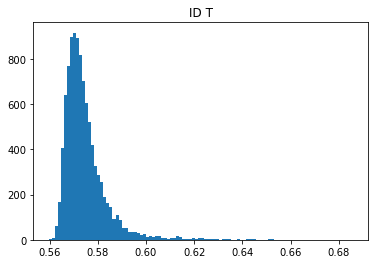

313/313 [==============================] - 1s 2ms/step


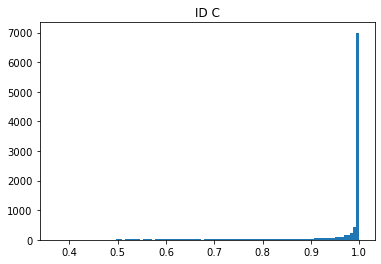

ID T:  0.5748145
ID C:  0.95881915
AUC T:  0.22314311851447297
AUC C:  0.5660864554888039


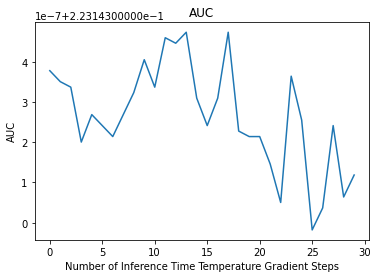

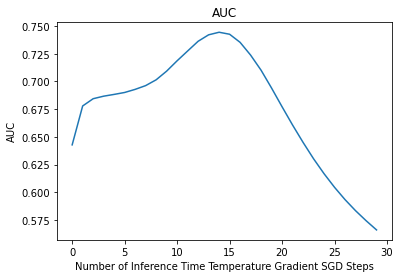

115/115 [==============================] - 0s 1ms/step


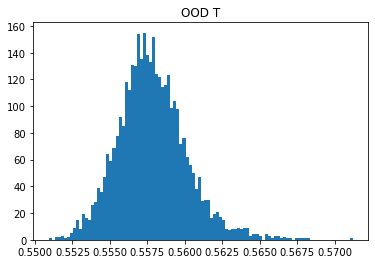

115/115 [==============================] - 0s 2ms/step


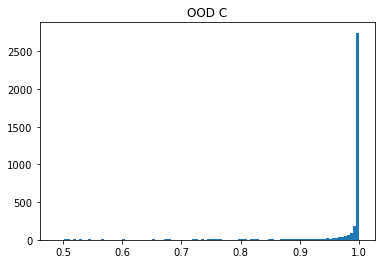

OOD T:  0.5578286
OOD C:  0.9745362
313/313 [==============================] - 0s 1ms/step


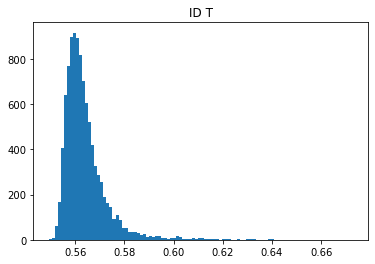

313/313 [==============================] - 1s 2ms/step


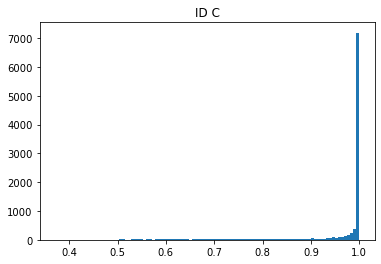

ID T:  0.56403816
ID C:  0.96193594
AUC T:  0.22314330966684873
AUC C:  0.5587484571272529


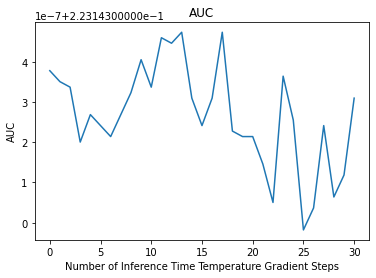

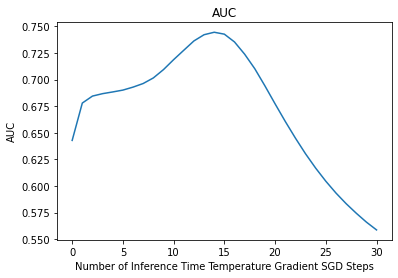

115/115 [==============================] - 0s 1ms/step


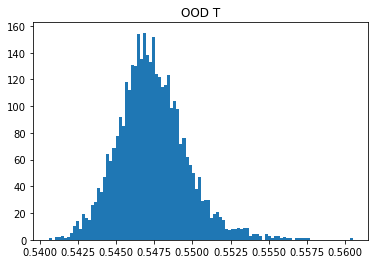

115/115 [==============================] - 0s 2ms/step


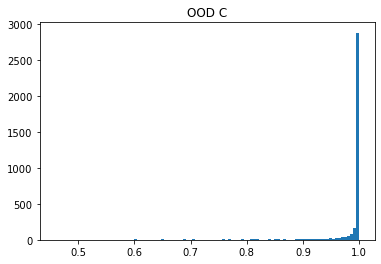

OOD T:  0.5473707
OOD C:  0.97864497
313/313 [==============================] - 0s 1ms/step


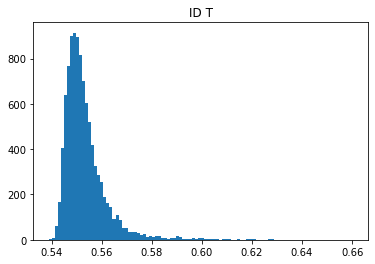

313/313 [==============================] - 1s 2ms/step


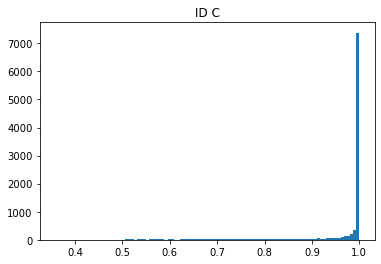

ID T:  0.55346394
ID C:  0.9646415
AUC T:  0.22314298197706173
AUC C:  0.5520947706171491


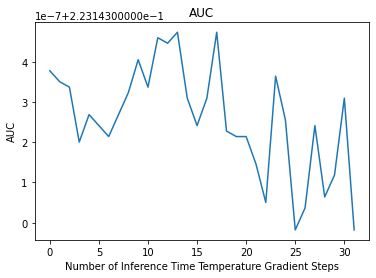

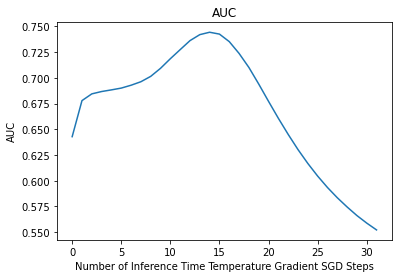

115/115 [==============================] - 0s 1ms/step


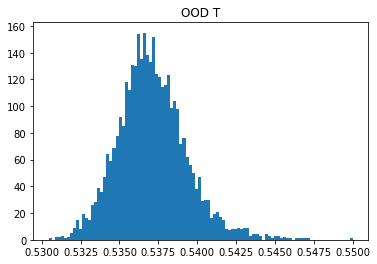

115/115 [==============================] - 0s 2ms/step


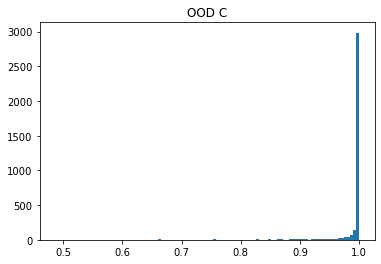

OOD T:  0.5371089
OOD C:  0.98171914
313/313 [==============================] - 0s 1ms/step


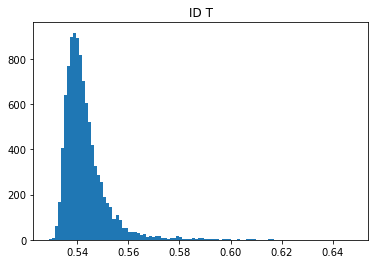

313/313 [==============================] - 1s 2ms/step


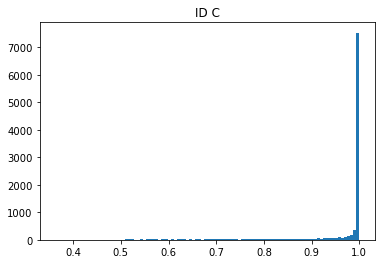

ID T:  0.5430877
ID C:  0.96681017
AUC T:  0.22314303659202625
AUC C:  0.5460613462588749


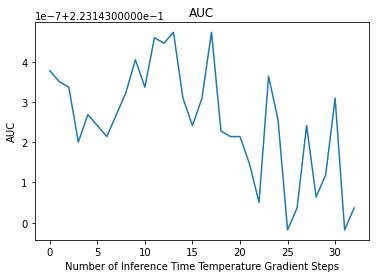

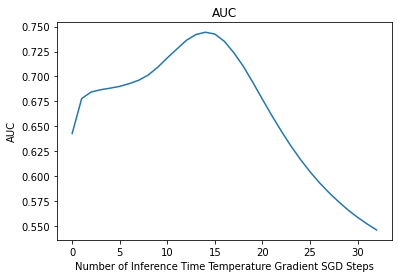

115/115 [==============================] - 0s 1ms/step


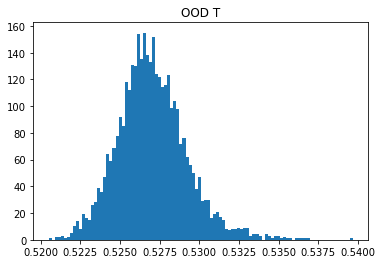

115/115 [==============================] - 0s 2ms/step


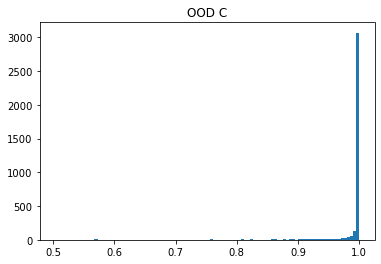

OOD T:  0.52703947
OOD C:  0.9841296
313/313 [==============================] - 0s 1ms/step


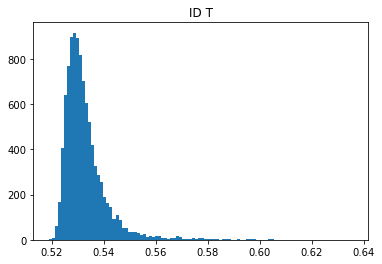

313/313 [==============================] - 1s 2ms/step


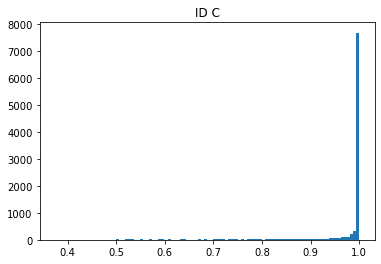

ID T:  0.5329063
ID C:  0.9683593
AUC T:  0.2231432550518842
AUC C:  0.5406536455488804


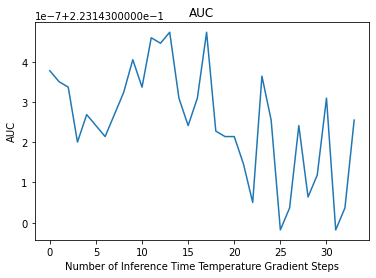

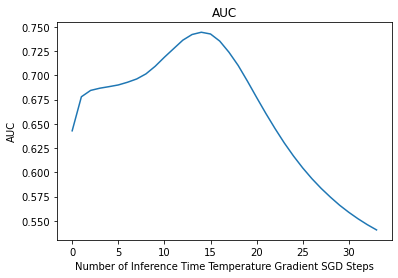

115/115 [==============================] - 0s 2ms/step


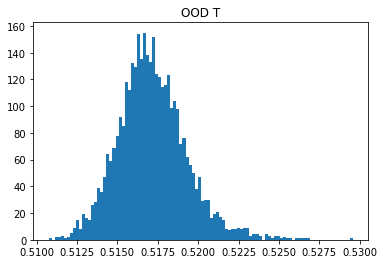

115/115 [==============================] - 0s 2ms/step


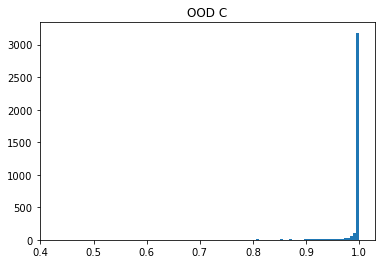

OOD T:  0.5171588
OOD C:  0.9864976
313/313 [==============================] - 0s 1ms/step


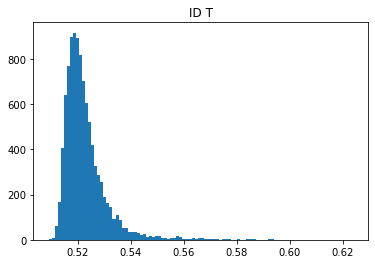

313/313 [==============================] - 1s 2ms/step


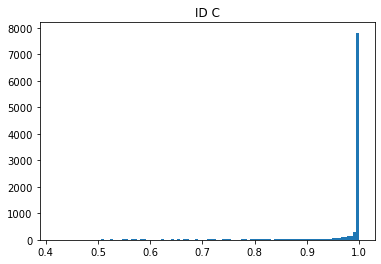

ID T:  0.52291566
ID C:  0.96988106
AUC T:  0.2231429273620972
AUC C:  0.5352889814309121


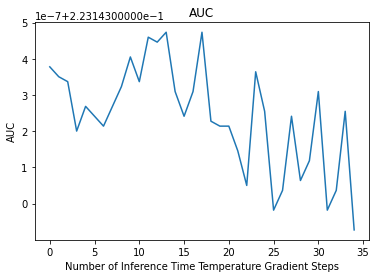

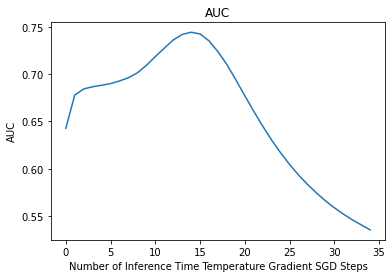

115/115 [==============================] - 0s 2ms/step


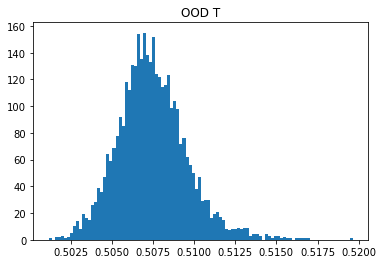

115/115 [==============================] - 0s 2ms/step


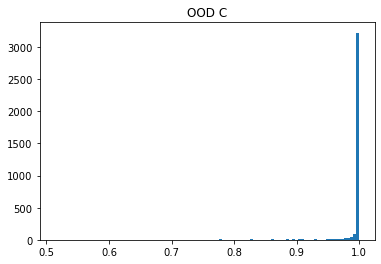

OOD T:  0.50746334
OOD C:  0.98875916
313/313 [==============================] - 0s 1ms/step


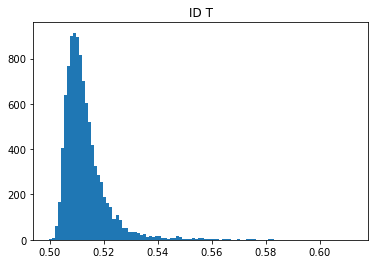

313/313 [==============================] - 1s 2ms/step


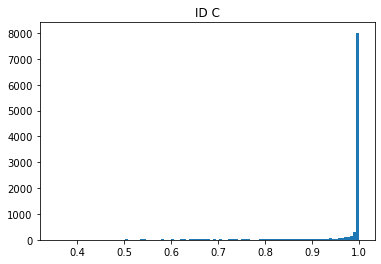

ID T:  0.5131123
ID C:  0.9718484
AUC T:  0.22314321409066085
AUC C:  0.5297682687056253


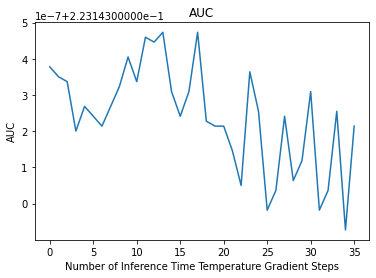

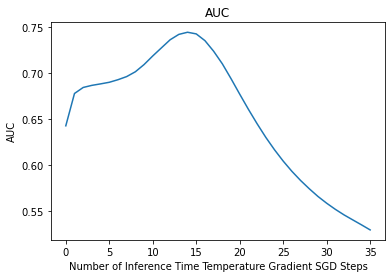

115/115 [==============================] - 0s 1ms/step


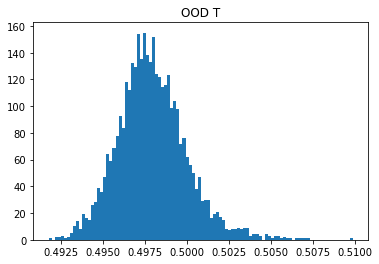

115/115 [==============================] - 0s 2ms/step


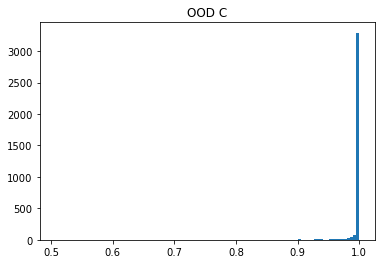

OOD T:  0.49794966
OOD C:  0.99036586
313/313 [==============================] - 0s 1ms/step


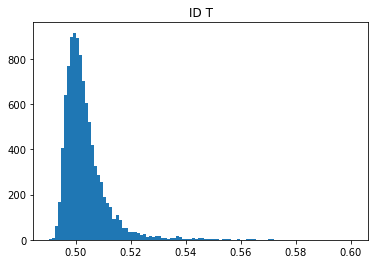

313/313 [==============================] - 1s 2ms/step


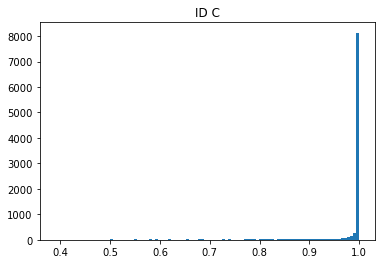

ID T:  0.50349265
ID C:  0.97354794
AUC T:  0.22314322774440196
AUC C:  0.5231698388858547


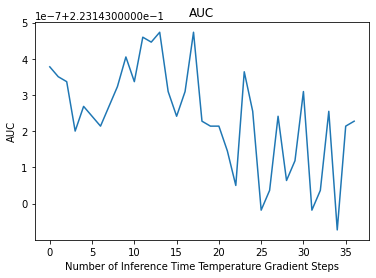

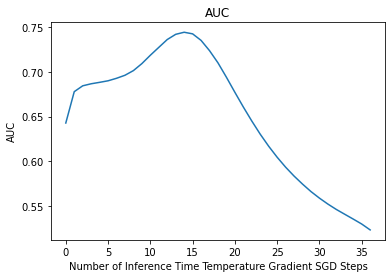

115/115 [==============================] - 0s 1ms/step


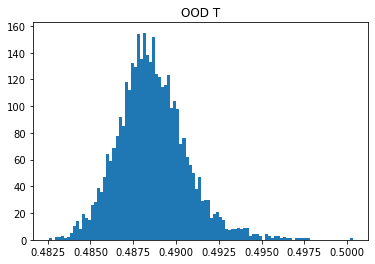

115/115 [==============================] - 0s 2ms/step


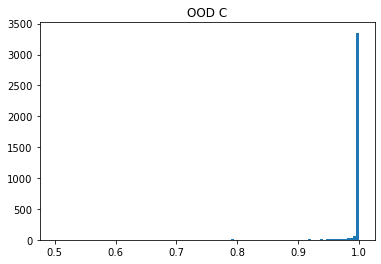

OOD T:  0.48861438
OOD C:  0.99161947
313/313 [==============================] - 0s 1ms/step


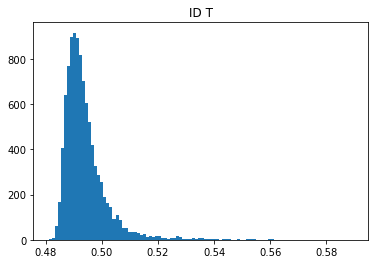

313/313 [==============================] - 1s 2ms/step


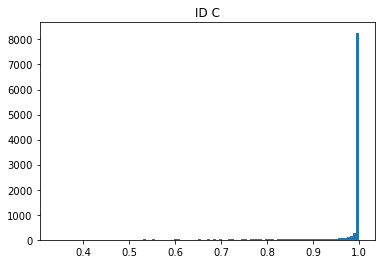

ID T:  0.4940535
ID C:  0.9754161
AUC T:  0.22314311851447294
AUC C:  0.5174201802293829


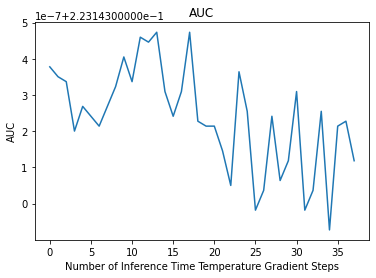

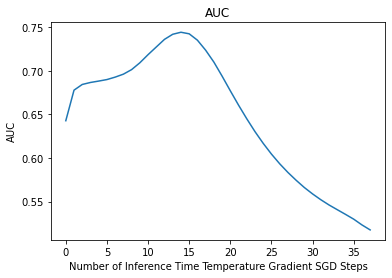

115/115 [==============================] - 0s 2ms/step


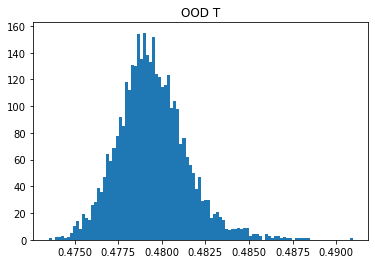

115/115 [==============================] - 0s 2ms/step


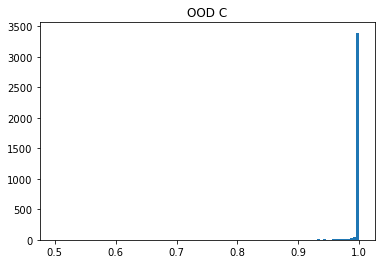

OOD T:  0.4794541
OOD C:  0.9928135
313/313 [==============================] - 0s 1ms/step


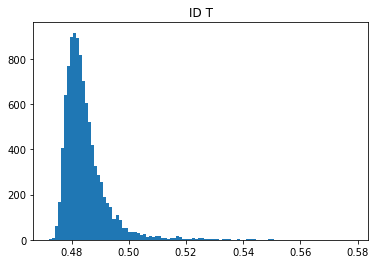

313/313 [==============================] - 1s 2ms/step


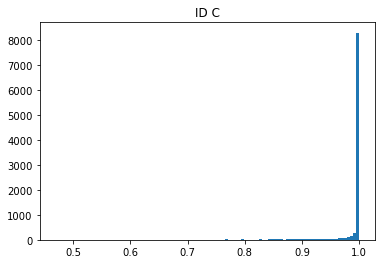

ID T:  0.48479122
ID C:  0.9776386
AUC T:  0.2231431731294375
AUC C:  0.511778495357728


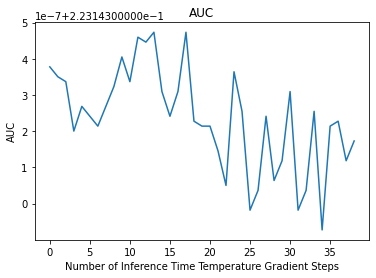

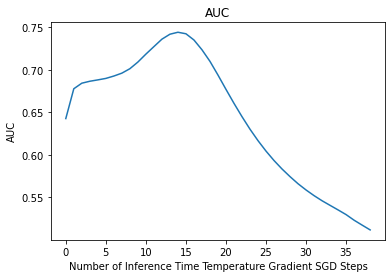

115/115 [==============================] - 0s 1ms/step


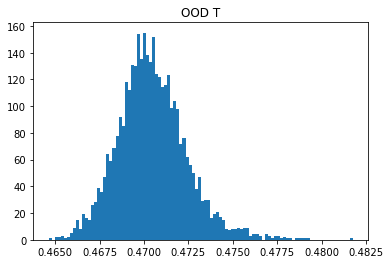

115/115 [==============================] - 0s 2ms/step


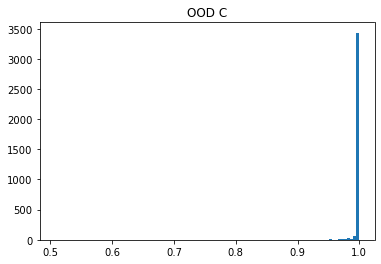

OOD T:  0.4704655
OOD C:  0.99367654
313/313 [==============================] - 0s 1ms/step


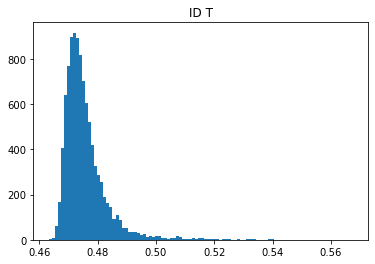

313/313 [==============================] - 1s 2ms/step


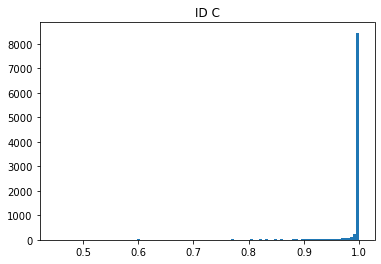

ID T:  0.47570258
ID C:  0.9795199
AUC T:  0.2231431731294375
AUC C:  0.5041765565264882


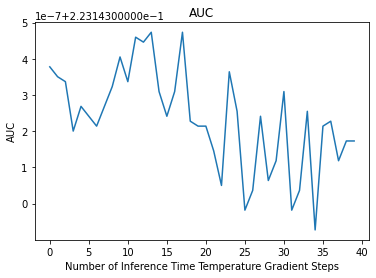

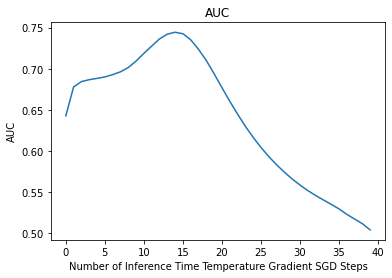

115/115 [==============================] - 0s 1ms/step


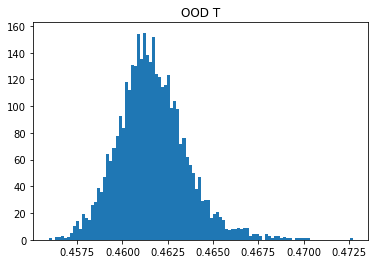

115/115 [==============================] - 0s 2ms/step


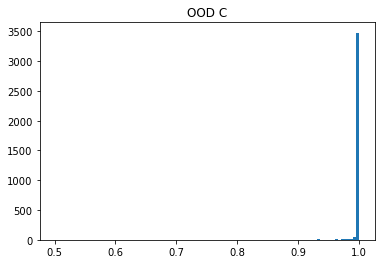

OOD T:  0.46164545
OOD C:  0.99413824
313/313 [==============================] - 0s 1ms/step


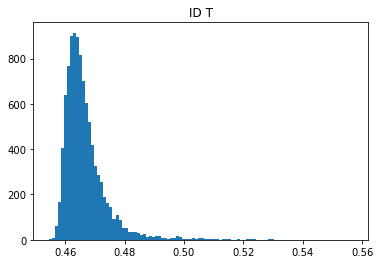

313/313 [==============================] - 1s 2ms/step


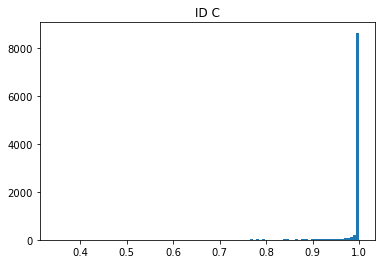

ID T:  0.4667844
ID C:  0.9812434
AUC T:  0.22314340524303658
AUC C:  0.49624291370835616


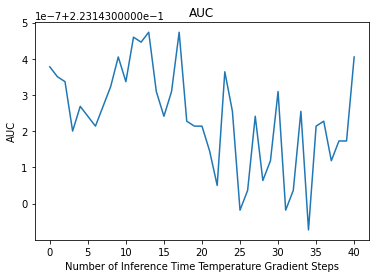

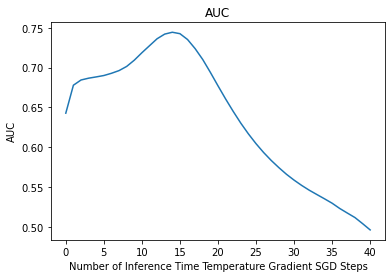

115/115 [==============================] - 0s 1ms/step


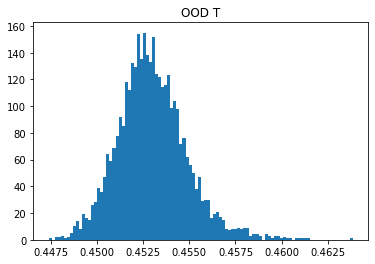

115/115 [==============================] - 0s 2ms/step


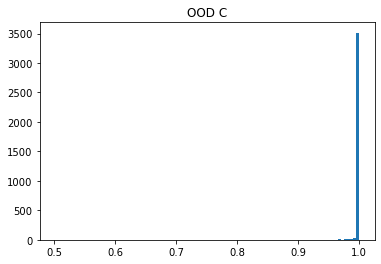

OOD T:  0.4529908
OOD C:  0.9946895
313/313 [==============================] - 0s 1ms/step


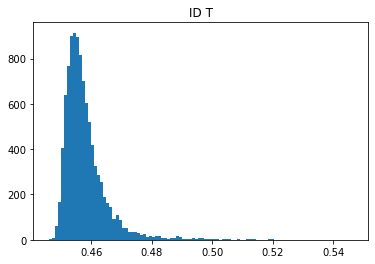

313/313 [==============================] - 1s 2ms/step


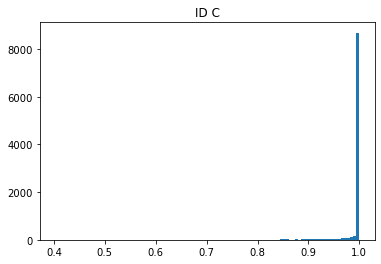

ID T:  0.4580333
ID C:  0.9826546
AUC T:  0.22314336428181325
AUC C:  0.48780106499180775


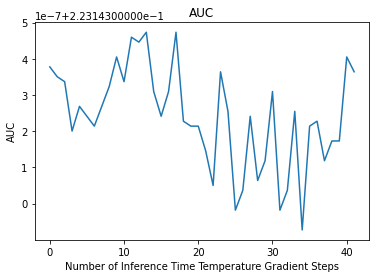

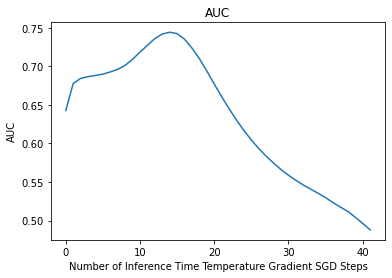

115/115 [==============================] - 0s 2ms/step


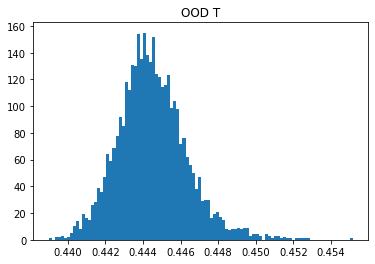

115/115 [==============================] - 0s 2ms/step


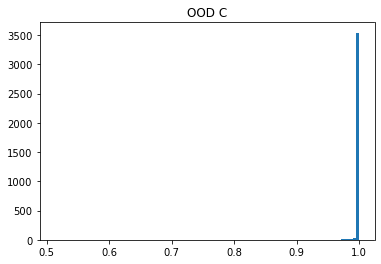

OOD T:  0.44449833
OOD C:  0.99598664
313/313 [==============================] - 0s 1ms/step


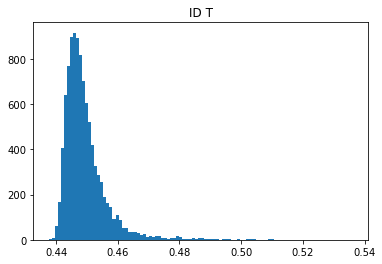

313/313 [==============================] - 1s 2ms/step


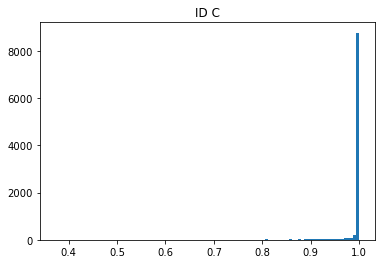

ID T:  0.44944635
ID C:  0.9837977
AUC T:  0.2231433642818132
AUC C:  0.47742876843255044


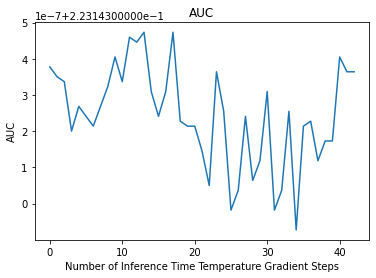

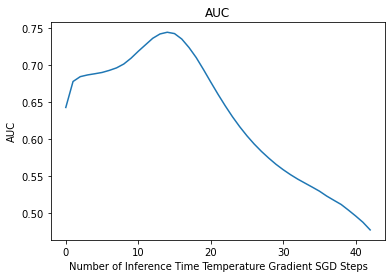

115/115 [==============================] - 0s 1ms/step


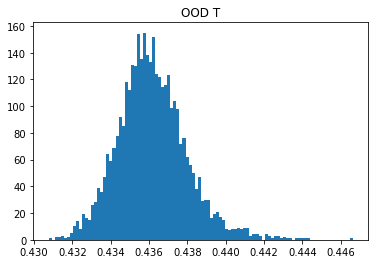

115/115 [==============================] - 0s 2ms/step


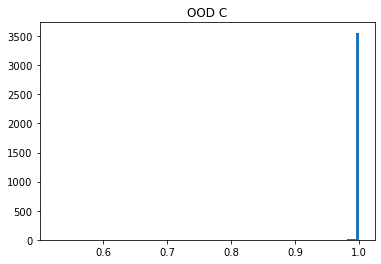

OOD T:  0.4361651
OOD C:  0.9970822
313/313 [==============================] - 0s 1ms/step


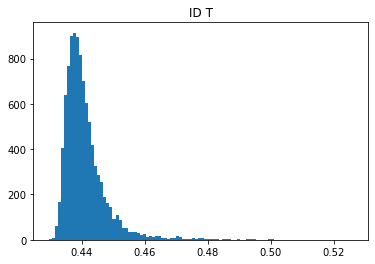

313/313 [==============================] - 1s 2ms/step


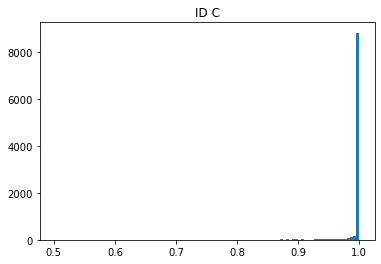

ID T:  0.44102037
ID C:  0.98484826
AUC T:  0.2231434598580011
AUC C:  0.46749654560349535


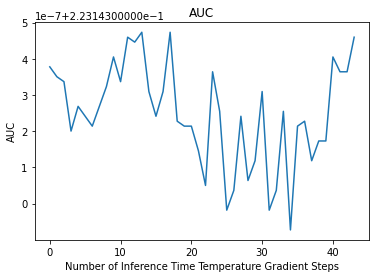

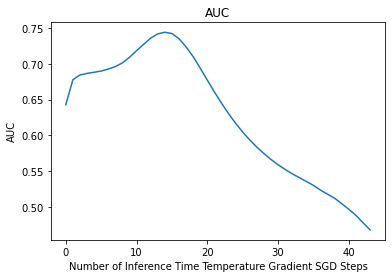

115/115 [==============================] - 0s 1ms/step


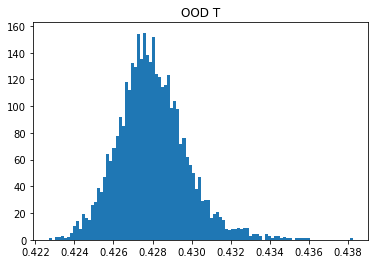

115/115 [==============================] - 0s 2ms/step


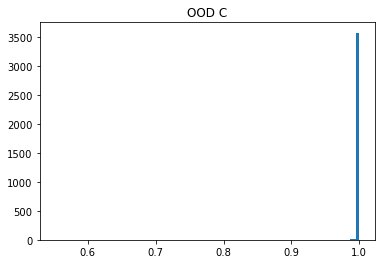

OOD T:  0.42798808
OOD C:  0.99780756
313/313 [==============================] - 0s 1ms/step


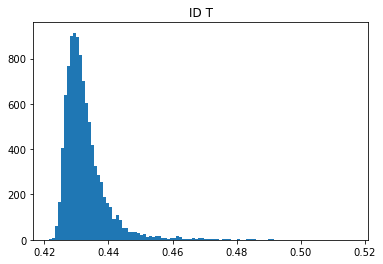

313/313 [==============================] - 1s 2ms/step


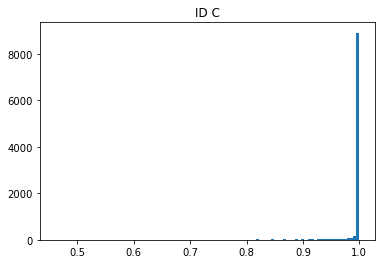

ID T:  0.43275234
ID C:  0.9861459
AUC T:  0.22314332332058984
AUC C:  0.45878995084653196


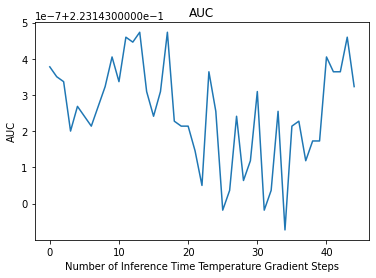

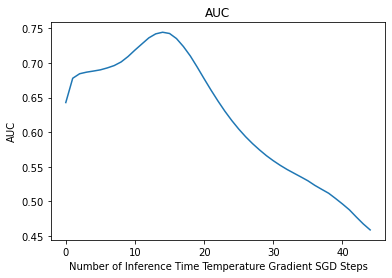

115/115 [==============================] - 0s 1ms/step


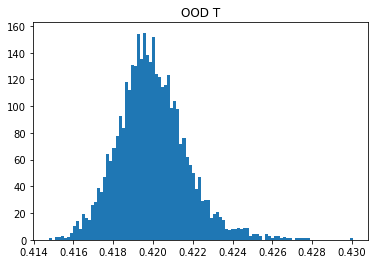

115/115 [==============================] - 0s 2ms/step


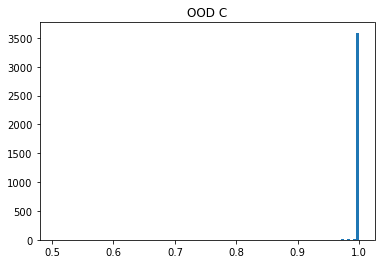

OOD T:  0.4199644
OOD C:  0.9983169
313/313 [==============================] - 0s 1ms/step


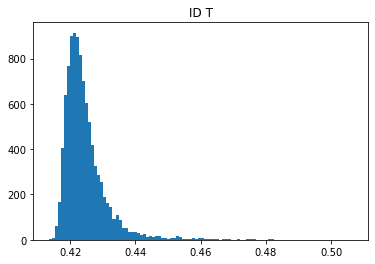

313/313 [==============================] - 1s 2ms/step


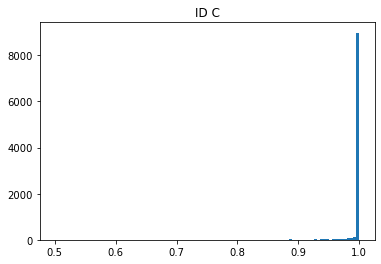

ID T:  0.4246393
ID C:  0.98711103
AUC T:  0.22314341889677775
AUC C:  0.4524650464227198


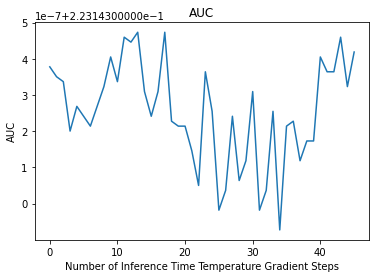

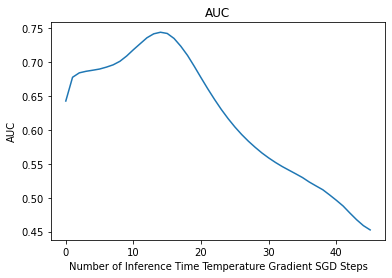

115/115 [==============================] - 0s 1ms/step


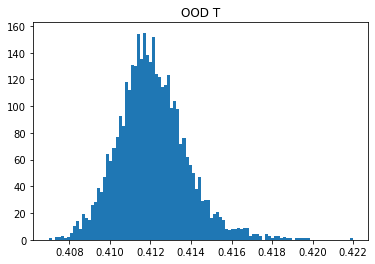

115/115 [==============================] - 0s 2ms/step


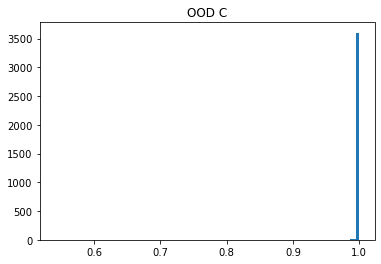

OOD T:  0.4120911
OOD C:  0.9987863
313/313 [==============================] - 0s 1ms/step


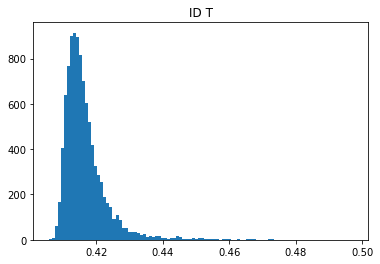

313/313 [==============================] - 1s 2ms/step


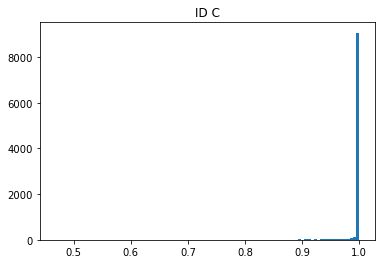

ID T:  0.41667837
ID C:  0.98806983
AUC T:  0.2231435144729656
AUC C:  0.4471128072091754


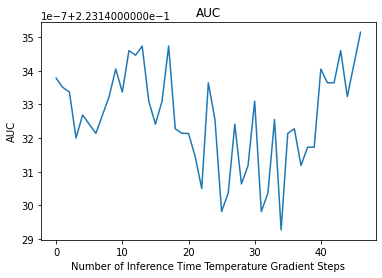

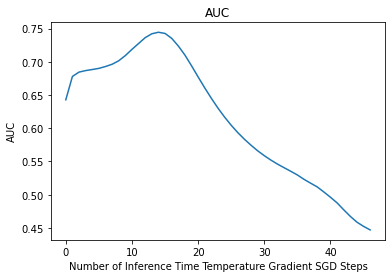

115/115 [==============================] - 0s 1ms/step


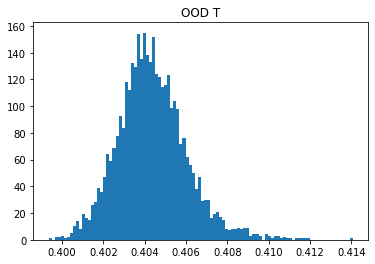

115/115 [==============================] - 0s 2ms/step


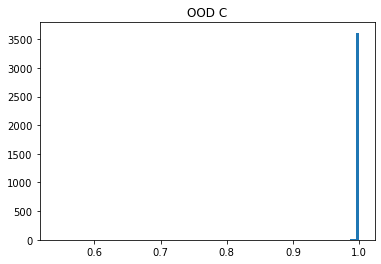

OOD T:  0.40436542
OOD C:  0.99910635
313/313 [==============================] - 0s 1ms/step


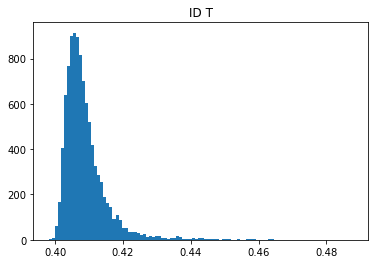

313/313 [==============================] - 1s 2ms/step


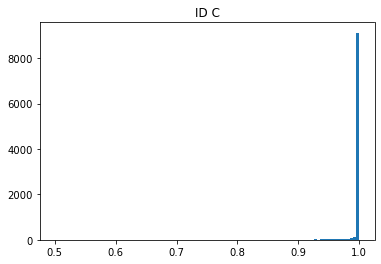

ID T:  0.4088667
ID C:  0.98916554
AUC T:  0.2231431867831786
AUC C:  0.44221772255598035


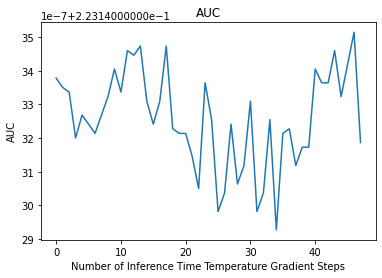

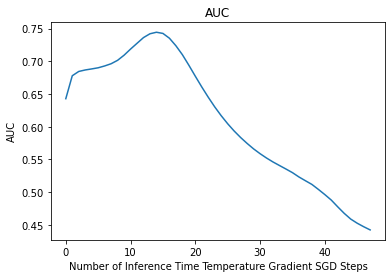

115/115 [==============================] - 0s 1ms/step


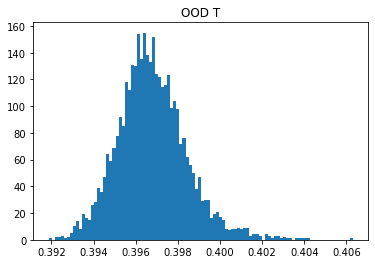

115/115 [==============================] - 0s 2ms/step


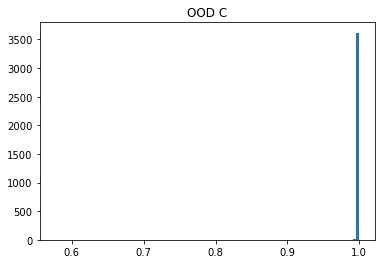

OOD T:  0.39678457
OOD C:  0.9993492
313/313 [==============================] - 0s 1ms/step


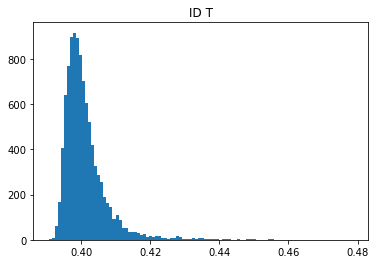

313/313 [==============================] - 1s 2ms/step


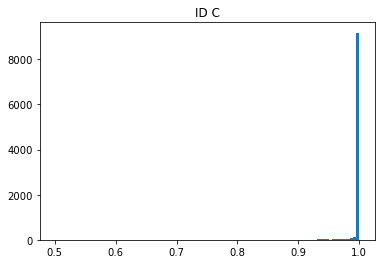

ID T:  0.40120146
ID C:  0.99013036
AUC T:  0.22314355543418896
AUC C:  0.4382776761332604


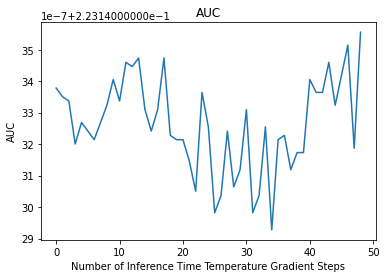

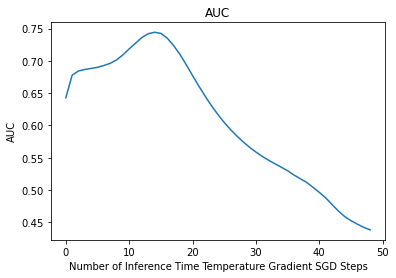

115/115 [==============================] - 0s 1ms/step


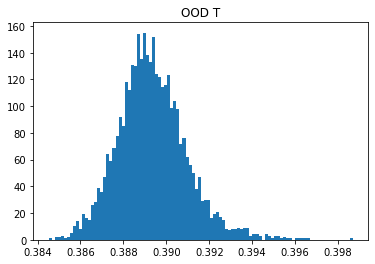

115/115 [==============================] - 0s 2ms/step


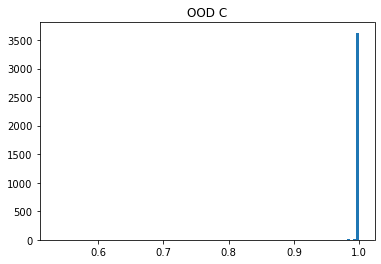

OOD T:  0.38934588
OOD C:  0.9995161
313/313 [==============================] - 0s 1ms/step


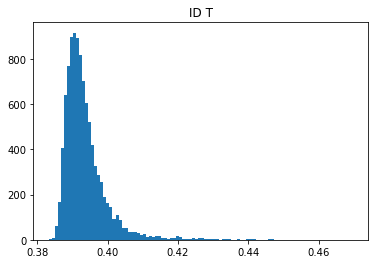

313/313 [==============================] - 1s 2ms/step


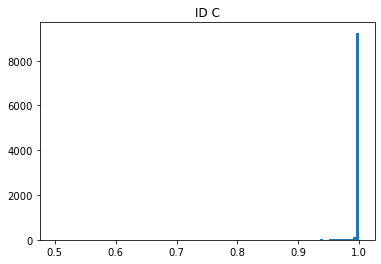

ID T:  0.39367998
ID C:  0.9908073
AUC T:  0.22314330966684875
AUC C:  0.43316303932277456


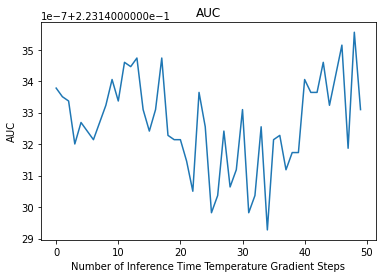

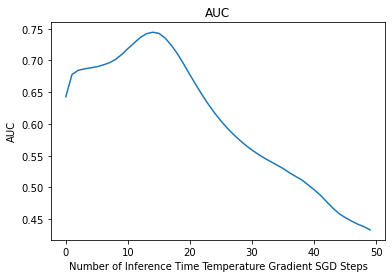

115/115 [==============================] - 0s 1ms/step


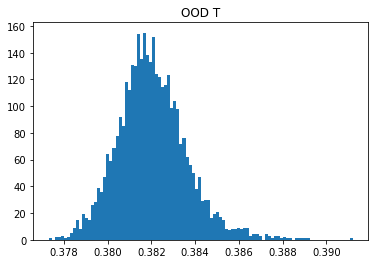

115/115 [==============================] - 0s 2ms/step


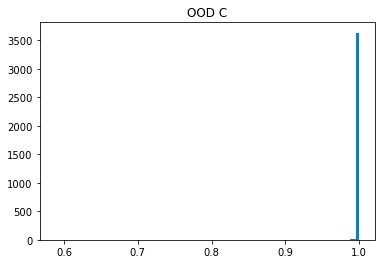

OOD T:  0.3820466
OOD C:  0.99966216
313/313 [==============================] - 0s 1ms/step


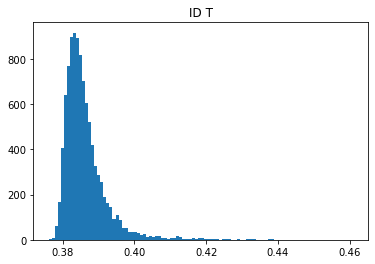

313/313 [==============================] - 1s 2ms/step


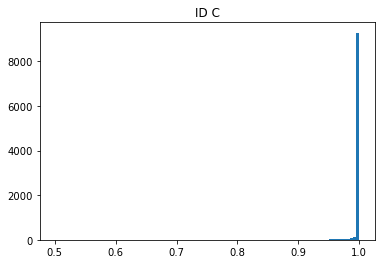

ID T:  0.38629943
ID C:  0.9914863
AUC T:  0.2231434735117422
AUC C:  0.43080791916985245


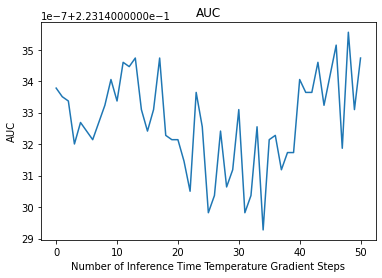

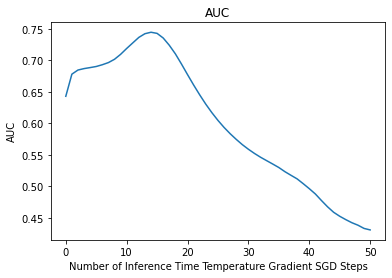

115/115 [==============================] - 0s 1ms/step


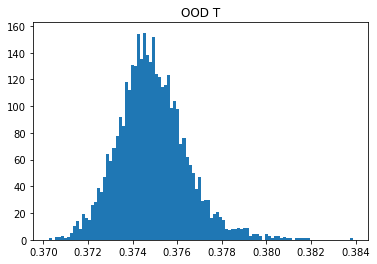

115/115 [==============================] - 0s 2ms/step


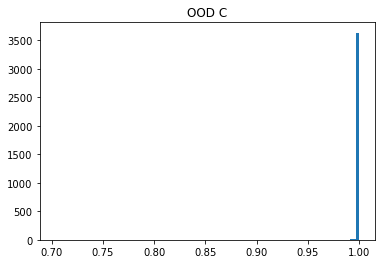

OOD T:  0.3748842
OOD C:  0.99977654
313/313 [==============================] - 0s 1ms/step


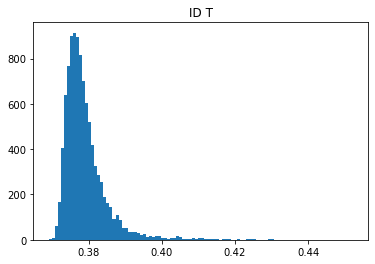

313/313 [==============================] - 1s 2ms/step


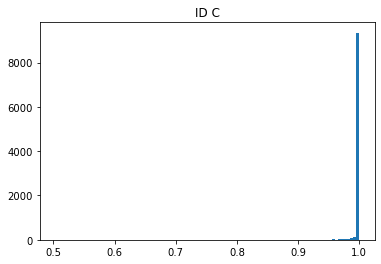

ID T:  0.3790573
ID C:  0.9920002
AUC T:  0.2231432004369197
AUC C:  0.43044313216821417


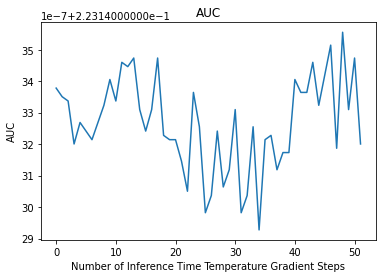

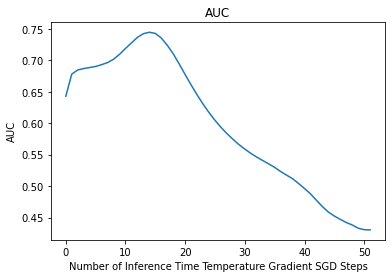

115/115 [==============================] - 0s 1ms/step


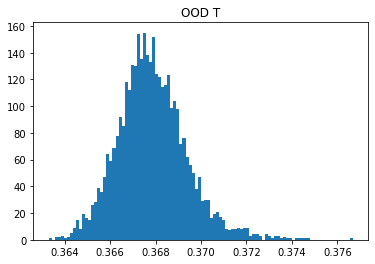

115/115 [==============================] - 0s 2ms/step


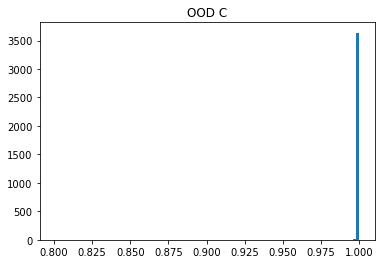

OOD T:  0.36785606
OOD C:  0.9998509
313/313 [==============================] - 0s 1ms/step


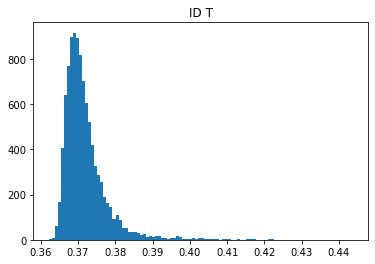

313/313 [==============================] - 1s 2ms/step


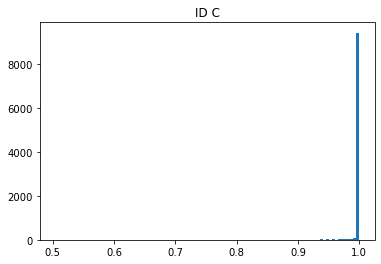

ID T:  0.3719509
ID C:  0.9922923
AUC T:  0.22314350081922446
AUC C:  0.4295166848716549


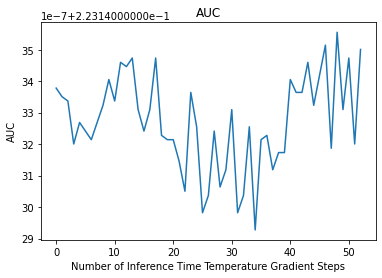

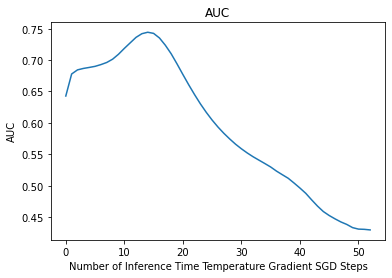

115/115 [==============================] - 0s 1ms/step


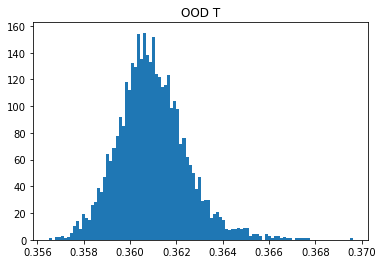

 31/115 [=======>......................] - ETA: 0s

KeyboardInterrupt: 

In [97]:
from sklearn.metrics import roc_auc_score
from copy import deepcopy
import tensorflow as tf
encoding_X_ood_grad = deepcopy(encoding_X_ood)
encoding_X_test_grad = deepcopy(encoding_X_test)
auc_ts = []
auc_cs = []
for _ in range(100):
    tensor = tf.convert_to_tensor(encoding_X_ood_grad, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(tensor)
        y = temperature_model(tensor)
        #pred = ood_network(tensor)
        #y = [pred[i, keras.backend.argmax(y_hat_ood[i])] for i in range(len(pred))]
    dy_dx = tape.gradient(y, tensor)
    dy_dx = ((np.array(dy_dx) > 0).astype('float32') - 0.5) * 2
    encoding_X_ood_grad -= 14e-2 * dy_dx
    ood_t = temperature_model.predict(encoding_X_ood_grad)
    plt.hist(ood_t, bins = 100)
    plt.title("OOD T")
    plt.show()
    ood_grad_c = np.max(ood_network.predict(encoding_X_ood_grad), axis = 1)
    plt.hist(ood_grad_c, bins = 100)
    plt.title("OOD C")
    plt.show()
    print("OOD T: ", np.nanmean(ood_t))
    print("OOD C: ", np.nanmean(ood_grad_c))


    tensor = tf.convert_to_tensor(encoding_X_test_grad, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(tensor)
        y = temperature_model(tensor)
        #pred = ood_network(tensor)
        #y = [pred[i, keras.backend.argmax(y_hat_test[i])] for i in range(len(pred))]
    dy_dx = tape.gradient(y, tensor)
    dy_dx = ((np.array(dy_dx) > 0).astype('float32') - 0.5) * 2
    encoding_X_test_grad -= 14e-2 *  dy_dx
    id_t = temperature_model.predict(encoding_X_test_grad)
    plt.hist(id_t, bins = 100)
    plt.title("ID T")
    plt.show()
    id_grad_c = np.max(ood_network.predict(encoding_X_test_grad), axis = 1)
    plt.hist(id_grad_c, bins = 100)
    plt.title("ID C")
    plt.show()
    print("ID T: ", np.nanmean(id_t))
    print("ID C: ", np.nanmean(id_grad_c))
    
    id_defined_indices = np.where([~np.isnan(v).any() for v in id_t])[0]
    ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_t])[0]
    auc_t = roc_auc_score(np.concatenate([np.zeros((len(id_defined_indices))), np.ones((len(ood_defined_indices)))]), np.concatenate([id_t[id_defined_indices], ood_t[ood_defined_indices]]))
    print("AUC T: ", auc_t)
    auc_ts.append(auc_t)
    id_defined_indices = np.where([~np.isnan(v).any() for v in id_grad_c])[0]
    ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_grad_c])[0]
    auc_c = roc_auc_score(np.concatenate([np.ones((len(id_defined_indices))), np.zeros((len(ood_defined_indices)))]), np.concatenate([id_grad_c[id_defined_indices], ood_grad_c[ood_defined_indices]]))
    print("AUC C: ", auc_c)
    auc_cs.append(auc_c)
    
    plt.plot(auc_ts)
    plt.title("AUC")
    plt.ylabel("AUC")
    plt.xlabel("Number of Inference Time Temperature Gradient Steps")
    plt.show()
    
    plt.plot(auc_cs)
    plt.title("AUC")
    plt.ylabel("AUC")
    plt.xlabel("Number of Inference Time Temperature Gradient SGD Steps")
    plt.show()

Text(0.5, 0, 'Number of Inference Time Temperature Gradient Steps')

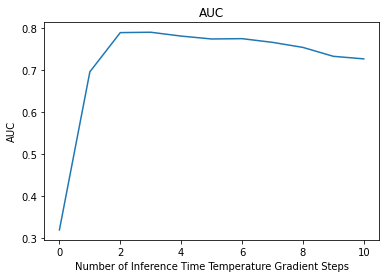

In [15]:
plt.plot(auc_ts)
plt.title("AUC")
plt.ylabel("AUC")
plt.xlabel("Number of Inference Time Temperature Gradient Steps")

In [16]:
id_temp_ungrad = temperature_model.predict(encoding_X_test)
ood_temp_ungrad = temperature_model.predict(encoding_X_ood)

Text(0.5, 0, 'Number of Inference Time Temperature Gradient SGD Steps')

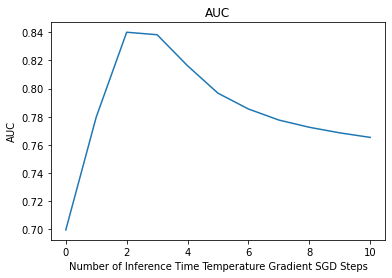

In [17]:
plt.plot(auc_cs)
plt.title("AUC")
plt.ylabel("AUC")
plt.xlabel("Number of Inference Time Temperature Gradient SGD Steps")

In [18]:
id_temp = temperature_model.predict(encoding_X_test)
print("In Distribution Temperature: ", np.nanmean(id_temp))

In Distribution Temperature:  0.79934955


In [19]:
id_grad_temp = temperature_model.predict(encoding_X_test_grad)
print("In Distribution Grad Temperature: ", np.nanmean(id_grad_temp))

In Distribution Grad Temperature:  47.489777


In [20]:
t = temperature_model.predict(np.array(vos_samples))
print("VO Temperature (we want this to be much higher than the in distribution temperature): ", np.nanmean(t))

VO Temperature (we want this to be much higher than the in distribution temperature):  44.274094


In [21]:
ood_temp = temperature_model.predict(encoding_X_ood)
print("OOD Temperature (we want this to be much higher than the in distribution temperature): ", np.nanmean(ood_temp))

OOD Temperature (we want this to be much higher than the in distribution temperature):  0.67657477


In [22]:
ood_grad_temp = temperature_model.predict(encoding_X_ood_grad)
print("OOD Grad Temperature (we want this to be much higher than the in distribution temperature): ", np.nanmean(ood_grad_temp))

OOD Grad Temperature (we want this to be much higher than the in distribution temperature):  57.00145


In [23]:
vos_pred = ood_network.predict(np.array(vos_samples))
print("Temperature Deflated VO Confidence Average (we want this to be really low): ", np.mean(np.max(vos_pred, axis = 1)))

Temperature Deflated VO Confidence Average (we want this to be really low):  0.1350687


In [24]:
ood_pred = ood_network.predict(encoding_X_ood)
print("Temperature Deflated OOD Confidence Average (we want this to be really low): ", np.mean(np.max(ood_pred, axis = 1)))

Temperature Deflated OOD Confidence Average (we want this to be really low):  0.8918524


In [25]:
ood_grad_pred = ood_network.predict(encoding_X_ood_grad)
print("Temperature Deflated OOD Grad Confidence Average (we want this to be really low): ", np.nanmean(np.max(ood_grad_pred, axis = 1)))

Temperature Deflated OOD Grad Confidence Average (we want this to be really low):  0.12015528


In [26]:
id_pred = ood_network.predict(encoding_X_test)
print("Temperature Deflated In-Distribution Confidence Average: ", np.nanmean(np.max(id_pred, axis = 1)))

Temperature Deflated In-Distribution Confidence Average:  0.9352877


In [27]:
id_grad_pred = ood_network.predict(encoding_X_test_grad)
print("Temperature Deflated In-Distribution Grad Confidence Average: ", np.nanmean(np.max(id_grad_pred, axis = 1)))

Temperature Deflated In-Distribution Grad Confidence Average:  0.15143062


In [28]:
id_defined_indices = np.where([~np.isnan(v).any() for v in id_pred])[0]
ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_pred])[0]
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred[id_defined_indices]))), np.zeros((len(ood_pred[ood_defined_indices])))]), np.concatenate([np.max(id_pred[id_defined_indices], axis = 1), np.max(ood_pred[ood_defined_indices], axis = 1)])))
id_defined_indices = np.where([~np.isnan(v).any() for v in id_grad_pred])[0]
ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_grad_pred])[0]
print("Grad AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_grad_pred[id_defined_indices]))), np.zeros((len(ood_grad_pred[ood_defined_indices])))]), np.concatenate([np.max(id_grad_pred[id_defined_indices], axis = 1), np.max(ood_grad_pred[ood_defined_indices], axis = 1)])))

AUC:  0.670211250682687
Grad AUC:  0.7622610731840525


In [29]:
vo_pred = ood_network.predict(np.array(vos_samples))
print("Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(vo_pred, axis = 1)))

Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD):  0.1350687


In [30]:
ood_pred = ood_network.predict(encoding_X_test)
print("Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(ood_pred, axis = 1)))

Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD):  0.9352877


In [31]:
id_pred = network.predict(X_test)
print("Unaffected Model In-Distribution Confidence Average: ", np.mean(np.max(id_pred, axis = 1)))

Unaffected Model In-Distribution Confidence Average:  0.9134581


In [32]:
id_defined_indices = np.where([~np.isnan(v).any() for v in id_pred])[0]
ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_pred])[0]
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred[id_defined_indices]))), np.zeros((len(ood_pred[ood_defined_indices])))]), np.concatenate([np.max(id_pred[id_defined_indices], axis = 1), np.max(ood_pred[ood_defined_indices], axis = 1)])))

AUC:  0.43315355000000005


In [72]:
def get_ece(confidences, correctness):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 50
    for i in range(num_bins):
        prop = i*1./num_bins
        inds = np.where((confidences >= prop) & (confidences <= prop+1./num_bins))[0]
        amts.append(len(inds))
        if len(inds) > 0:
            hists.append(len(np.where(correctness[inds] == 1)[0])*1./len(inds))
            hists_hat.append(np.mean(confidences[inds]))
        else:
            hists.append(prop)
            hists_hat.append(prop + 0.5/num_bins)
    return np.sum(np.abs(np.array(hists) - np.array(hists_hat)) * np.array(amts)) / np.sum(amts)

In [73]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred = network.predict(X_test)

class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
print("Class ECE: ",np.mean(class_eces))
print("Accuracy ECE: ", get_ece(np.max(pred, axis = 1), y_test == np.argmax(pred, axis = 1)))

Class ECE:  0.03969899337525392
Accuracy ECE:  0.1825550391495228


In [74]:
pred = ood_network.predict(encoding_X_test)
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
print("Class ECE: ",np.mean(class_eces))
print("Accuracy ECE: ", get_ece(np.max(pred, axis = 1), y_test == np.argmax(pred, axis = 1)))

Class ECE:  0.04314916023276629
Accuracy ECE:  0.20417238867878915


In [75]:
model_predictions = encoding_network.predict(encoding_X_test)
ood_model_predictions = ood_network.predict(encoding_X_test)

In [76]:
num_intervals = 10

In [77]:
ood_scores_test = temperature_model.predict(encoding_X_test)[:, 0]

In [78]:
#z_scores = p_label_error / (variance_confidences + 1e-12)
from sklearn.metrics import average_precision_score
order = np.argsort(ood_scores_test)
ps = []
accs = []
base_class_eces = []
ood_model_class_eces = []
base_eces = []
ood_model_eces = []
base_confidences = []
ood_model_confidences = []
model_acc = []
ood_model_acc = []

for i in range(0, len(y_test), int(len(y_test) / num_intervals)):
    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    base_class_eces.append(np.mean(class_eces))
    base_eces.append(get_ece(np.max(model_predictions[order[:i + int(len(y_test) / num_intervals)]], axis = 1), y_test[order[:i + int(len(y_test) / num_intervals)]] == np.argmax(model_predictions[order[:i + int(len(y_test) / num_intervals)]], axis = 1)))
    base_confidences.append(np.mean(model_predictions[order[i:i + int(len(y_test) / num_intervals)], 1]))
    model_acc.append(np.mean(np.argmax(model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == 1))

    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(ood_model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    ood_model_class_eces.append(np.mean(class_eces))
    ood_model_eces.append(get_ece(np.max(ood_model_predictions[order[:i + int(len(y_test) / num_intervals)]], axis = 1), y_test[order[:i + int(len(y_test) / num_intervals)]] == np.argmax(ood_model_predictions[order[:i + int(len(y_test) / num_intervals)]], axis = 1)))
    ood_model_confidences.append(np.mean(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)], 1]))
    ood_model_acc.append(np.mean(np.argmax(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == 1))

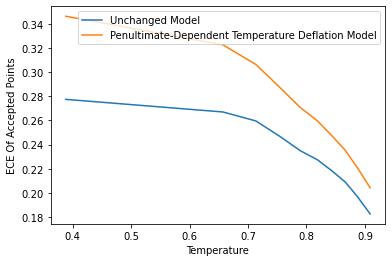

In [79]:
import matplotlib.pyplot as plt
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], base_eces, label = "Unchanged Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), base_eces, label = "Unchanged Model")
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
plt.xlabel("Temperature")
plt.ylabel("ECE Of Accepted Points")
plt.legend()

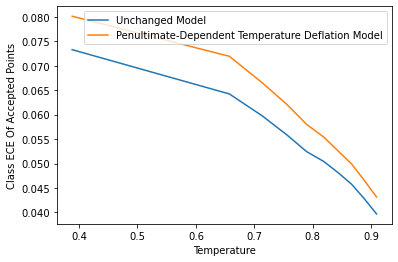

In [80]:
import matplotlib.pyplot as plt
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], base_class_eces, label = "Unchanged Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), base_eces, label = "Unchanged Model")
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], ood_model_class_eces, label = "Penultimate-Dependent Temperature Deflation Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
plt.xlabel("Temperature")
plt.ylabel("Class ECE Of Accepted Points")
plt.legend()

The blue line increasing shows that when temperature is high, ECE is high -> we can detect when the baseline model is miscalibrated (when we're OOD) and we know it by a high temperature. On this, we deflate confidence.

The orange line being lower shows that when we deflate the temperature, it does increase calibration.